In [5]:
from __future__ import print_function, division
import scipy


import keras
from keras.datasets import mnist
#from keras_contrib.layers.normalization import InstanceNormalization
from keras.layers import Input, Dense, Reshape, Flatten, Dropout, Concatenate
from keras.layers import BatchNormalization, Activation, ZeroPadding2D
from keras.layers.advanced_activations import LeakyReLU
from keras.layers.convolutional import UpSampling2D, Conv2D
from keras.models import Sequential, Model
from keras.optimizers import Adam, SGD
import datetime
import matplotlib.pyplot as plt
import sys
from data_loader import DataLoader
import numpy as np
import os
from glob import glob

Using Theano backend.
WARNING (theano.tensor.blas): Using NumPy C-API based implementation for BLAS functions.
Using cuDNN version 5110 on context None
Mapped name None to device cuda: TITAN X (Pascal) (0000:01:00.0)


In [6]:
def gen_data(f_mean_shift=(2,3), fvar=2, g_mean_shift=(-1,-1), gvar=0.5, num_pts=10000, mean=(0,0), var=1.0, batch_size=1):
        #data_type = "train%s" % domain if not is_testing else "test%s" % domain
        cov=var*np.eye(2)
        orig = np.random.multivariate_normal(mean, cov, num_pts)
        fmean=np.asarray(mean)+np.asarray(f_mean_shift)
        fpts= np.random.multivariate_normal(fmean, fvar*cov, num_pts)
        gmean=np.asarray(mean)+np.asarray(g_mean_shift)
        gpts=np.random.multivariate_normal(gmean, gvar*cov, num_pts)

        return orig, fpts, gpts

In [31]:
#translate from one determinisitcally generated distribution to another 
def translate_pt(a_pt, a_mean=(2,3), avar=2, b_mean=(-1,-1), bvar=0.5, mean=(0,0), var=1.0):
    #think of the point-mean as a vector that is scaled by the variance of the distribution 
    vec=(np.asarray(a_pt)-np.asarray(a_mean))
    #divide by the original dist's variance, re-scale by the new variance
    #the shift the vector to its new starting place, the mean of the target distribution
    b_trans_pt=np.asarray(np.asarray((np.asarray(vec)/avar))*bvar)+np.asarray(b_mean)
    return b_trans_pt



In [83]:
class CycleGAN():
    def __init__(self, data_A, data_B, lr_G=0.001, lr_D=0.0005, lambda_cycle=1, 
                 disclossconst=1, idloss=0.01, disclossfunc='binary_crossentropy', seed=997):
        
        #
        self.data_shape=(2,)
        self.data_dim=2
        self.disclossconst=disclossconst
        self.idloss=idloss
        self.disclossfunc=disclossfunc
        self.seed=seed

        # Loss weights
        ##################################
        # First change: set cycle-consistency weight to unit.
        # Could probably do the same to identity-loss weight
        # without much change, but the lambda_cycle weight
        # did seem to have an effect
        ##################################
        self.lambda_cycle = lambda_cycle                    # Cycle-consistency loss
        self.lambda_id = self.idloss * self.lambda_cycle    # Identity loss

        ##################################
        # Second change: optimizers
        # Start with SGD on easy data, then consider using Adam/RMSprop when you
        # get a feel for how training will go. The former is simpler and more
        # predictable, the latter can be erratic if you don't understand how to
        # set the hyperparameters.
        #
        # And then: different learning rates for generator and discriminator.
        # I'm suspicious of anyone who doesn't do this unless the discriminator
        # is non-sigmoid.
        # I'm suspicious of non-sigmoid discriminators except Wasserstein GAN.
        ##################################
        optimizer_G = SGD(lr=lr_G)
        optimizer_D = SGD(lr=lr_D)

        ##################################
        # Third change: discriminator loss
        # The original CycleGAN authors used MSE instead of BCE.
        # They cited some paper I've never heard of which claimed
        # that it encourages stability.
        # This sounds like a poor-man's Wasserstein GAN without
        # any of the analysis to back it up, FWIW.
        # Switched back to BCE because we know it works on
        # other types of GANs.
        #
        # ALSO: The discriminator's output layer had a sigmoid
        # activation, which doesn't make sense with MSE.
        # If you look in the original cyclegan.py, the
        # discriminator's final layer was the default activation,
        # which is linear. This makes more sense with MSE.
        # I also tried leaving MSE loss, and making the discriminator's
        # last activation linear, but that didn't work as well.
        ##################################
        self.d_A = self.build_discriminator()
        self.d_B = self.build_discriminator()
        self.d_A.compile(loss=self.disclossfunc,
            optimizer=optimizer_D,
            metrics=['accuracy'])
        self.d_B.compile(loss=self.disclossfunc,
            optimizer=optimizer_D,
            metrics=['accuracy'])

        #-------------------------
        # Construct Computational
        #   Graph of Generators
        #-------------------------
        np.random.seed(self.seed)
        # Build the generators
        self.g_AB = self.build_generator()
        self.g_BA = self.build_generator()

        # Input instances from both domains
        datum_A = Input(shape=self.data_shape)
        datum_B = Input(shape=self.data_shape)


        #Is this going to work the way I have it here
        #or should I be taking something from a batch?
        # Translate images to the other domain
        fake_B = self.g_AB(datum_A)
        fake_A = self.g_BA(datum_B)
        # Translate images back to original domain
        reconstr_A = self.g_BA(fake_B)
        reconstr_B = self.g_AB(fake_A)
        # Identity mapping of images
        datum_A_id = self.g_BA(datum_A)
        datum_B_id = self.g_AB(datum_B)

        # For the combined model we will only train the generators
        self.d_A.trainable = False
        self.d_B.trainable = False

        # Discriminators determines validity of translated images
        valid_A = self.d_A(fake_A)
        valid_B = self.d_B(fake_B)

        ##################################
        # Third change (part two): consistent switch to BCE
        # for all discriminator losses
        ##################################
        # Combined model trains generators to fool discriminators
        self.combined = Model(inputs=[datum_A, datum_B],
                              outputs=[ valid_A, valid_B,
                                        reconstr_A, reconstr_B,
                                        datum_A_id, datum_B_id ])
        self.combined.compile(loss=[self.disclossfunc, self.disclossfunc,
                                    'mae', 'mae',
                                    'mae', 'mae'],
                            loss_weights=[  self.disclossconst, self.disclossconst,
                                            self.lambda_cycle, self.lambda_cycle,
                                            self.lambda_id, self.lambda_id ],
                            optimizer=optimizer_G)

    

    def build_generator(self):
        """
        Simple MLP generator for the MoG unrolled GAN toy experiment
        """

        gen_input = Input(shape=(self.data_dim,), name="generator_input")

        ##################################
        # Fourth change: made this tanh instead of relu.
        # I suspect the important thing is to have similar activations
        # in generator and discriminator, but who knows.
        # Could also try relu in both, but I would use LeakyReLU.
        ##################################
        x = Dense(2*self.data_dim)(gen_input)
        x = Activation("tanh")(x)
     #     for i in range(2):
        x = Dense(2*self.data_dim)(x)
        x = Activation("tanh")(x)
        x = Dense(2)(gen_input)
        

        generator_model = Model(inputs=[gen_input], outputs=[x])
        #visualize_model(generator_model)

        return generator_model

#        
    def build_discriminator(self):

        """
        Simple MLP discriminator for the MoG unrolled GAN toy experiment
        """

        disc_input = Input(shape=(2,), name="discriminator_input")

        x = Dense(2*self.data_dim)(disc_input)
        x = Activation("tanh")(x)
    #     for i in range(2):
        x = Dense(2*self.data_dim)(x)
        x = Activation("tanh")(x)
        x = Dense(1, activation="sigmoid")(x)

        discriminator_model = Model(inputs=[disc_input], outputs=[x])
        #visualize_model(discriminator_model)

        #is there a difference between what this returns and the original cycelgan does?
        return discriminator_model

    
    def train(self, epochs, batch_size=1, sample_interval=50):

        start_time = datetime.datetime.now()
        np.random.seed(self.seed)

        # Adversarial loss ground truths
        valid = np.ones((batch_size,)) #+ self.disc_patch)
        fake = np.zeros((batch_size,)) #+ self.disc_patch)
#         self.g_AB.summary()
#         self.g_BA.summary()
#         self.d_A.summary()
#         self.d_B.summary()
        self.n_batches = int(min(len(data_A), len(data_B)) / batch_size)
        #total_samples = self.n_batches * batch_size
        for epoch in range(epochs):
            for i in range(self.n_batches-1):
                #randomly shuffle data?
                
                #take the corresponding "Batch size" number of elements
                batch_A = data_A[i*batch_size:(i+1)*batch_size]
                batch_B = data_B[i*batch_size:(i+1)*batch_size]
                #put them through this thing
                
                
                # ----------------------
                #  Train Discriminators
                # ----------------------
               # print(imgs_A.shape)

                # Translate images to opposite domain
                fake_B = self.g_AB.predict(batch_A)
                fake_A = self.g_BA.predict(batch_B)
                #print(fake_A.shape)
                #print(fake_B.shape)
                # Train the discriminators (original images = real / translated = Fake)
                dA_loss_real = self.d_A.train_on_batch(batch_A, valid)
                dA_loss_fake = self.d_A.train_on_batch(fake_A, fake)
                dA_loss = 0.5 * np.add(dA_loss_real, dA_loss_fake)

                dB_loss_real = self.d_B.train_on_batch(batch_B, valid)
                dB_loss_fake = self.d_B.train_on_batch(fake_B, fake)
                dB_loss = 0.5 * np.add(dB_loss_real, dB_loss_fake)

                # Total disciminator loss
                d_loss = 0.5 * np.add(dA_loss, dB_loss)


                # ------------------
                #  Train Generators
                # ------------------

                # Train the generators
                g_loss = self.combined.train_on_batch([batch_A, batch_B],
                                                        [valid, valid,
                                                        batch_A, batch_B,
                                                        batch_A, batch_B])

                elapsed_time = datetime.datetime.now() - start_time
                
                #question: when you call predict on a generator, does it return elements
                #in the same order you send them in?
                #because i'm assuming here that fake_a[i] will correspond to batch_b[i]. IS this true?
                #until I know, I'll stick to batch size 1 always
                translation_acc_AB=np.asarray([])
                translation_acc_BA=np.asarray([])
                translation_max_BA=np.asarray([])
                translation_min_AB=np.asarray([])
                #computes the average euclidean distance between a-->translated->b, 
                #and the corresponding point that cyclegan generated 
                translation_acc_AB=np.append(translation_acc_AB, (np.asarray(
                    [scipy.spatial.distance.euclidean(
                        (translate_pt(a, (10,10), 3, (-7,6), .25)), bf) for (a,bf) in zip(batch_A, fake_B) ]).mean()))
                translation_acc_BA=np.append(translation_acc_AB, (np.asarray(
                    [scipy.spatial.distance.euclidean(
                        (translate_pt(b, (-7,6), .25, (10,10), 3)), af) for (b,af) in zip(batch_B, fake_A) ]).mean()))
                
                #computes the minimum euclidean distance between a-->translated->b, 
                #and the corresponding point that cyclegan generated 
                translation_min_AB=np.append(translation_acc_AB, (np.asarray(
                    [scipy.spatial.distance.euclidean(
                        (translate_pt(a, (10,10), 3, (-7,6), .25)), bf) for (a,bf) in zip(batch_A, fake_B) ]).min()))
                translation_min_BA=np.append(translation_acc_AB, (np.asarray(
                    [scipy.spatial.distance.euclidean(
                        (translate_pt(b, (-7,6), .25, (10,10), 3)), af) for (b,af) in zip(batch_B, fake_A) ]).min()))
                
                #computes the maximum euclidean distance between a-->translated->b, 
                #and the corresponding point that cyclegan generated 
                translation_max_AB=np.append(translation_acc_AB, (np.asarray(
                    [scipy.spatial.distance.euclidean(
                        (translate_pt(a, (10,10), 3, (-7,6), .25)), bf) for (a,bf) in zip(batch_A, fake_B) ]).max()))
                translation_max_BA=np.append(translation_acc_AB, (np.asarray(
                    [scipy.spatial.distance.euclidean(
                        (translate_pt(b, (-7,6), .25, (10,10), 3)), af) for (b,af) in zip(batch_B, fake_A) ]).max()))
    
                # Plot the progress
            if epoch % sample_interval == 0:
                print ("[Epoch %d/%d] [Batch %d/%d] [D loss: %f, acc: %3d%%] \n  [Translation AB Dist: %f BA Dist: %f Min AB Dist: %f Max AB: %f Min BA: %fMax BA: %f] \n [G loss: %05f, adv: %05f, recon: %05f, id: %05f] time: %s " \
                                                                        % ( epoch, epochs,
                                                                            i, self.n_batches,
                                                                            d_loss[0], 100*d_loss[1],
                                                                            np.asarray(translation_acc_AB).mean(),
                                                                            np.asarray(translation_acc_BA).mean(),
                                                                            np.asarray(translation_min_AB).mean(),
                                                                            np.asarray(translation_max_AB).mean(),
                                                                            np.asarray(translation_min_BA).mean(),
                                                                            np.asarray(translation_max_BA).mean(),
                                                                            g_loss[0], 
                                                                            np.mean(g_loss[1:3]),
                                                                            np.mean(g_loss[3:5]),
                                                                            np.mean(g_loss[5:6]),
                                                                            elapsed_time))

            # If at save interval => save generated image samples
            if epoch % sample_interval == 0:
                self.sample_data(epoch, i)

    def sample_data(self, epoch, batch_i):
       # r, c = 2, 3

        orig2, pic_data_A, pic_data_B= gen_data((10,10), 3, (-7,6), .25, 1000)
        
    
        # Translate images to the other domain
        fake_B = self.g_AB.predict(pic_data_A)
        fake_A = self.g_BA.predict(pic_data_B)
        # Translate back to original domain
        reconstr_A = self.g_BA.predict(fake_B)
        reconstr_B = self.g_AB.predict(fake_A)
        
        #give the translation accuracy for a random element
        #I'm not doing the average because I'm not sure the fake and real correspond 1-1
        #I can change this later if I think they do
        num=np.random.randint(len(fake_A[0]))
        trans_acc_AB= np.asarray(
                    [scipy.spatial.distance.euclidean((translate_pt(pic_data_A[num])), fake_B[num])])
        trans_acc_BA= np.asarray(
                    [scipy.spatial.distance.euclidean((translate_pt(pic_data_B[num])), fake_A[num])])
#         translation_acc_AB.append= np.asarray(
#                     [scipy.spatial.distance.euclidean((translate_pt(a)), bf) for (a,bf) in zip(batch_A, fake_B) ]).mean()
#         translation_acc_BA.append= np.asarray(
#                     [scipy.spatial.distance.euclidean((translate_pt(b)), af) for (b,af) in zip(batch_B, fake_A) ]).mean()
    
        #print("[Trans Dist AB: %d Dist: %d]" \ %(trans_acc_AB, trans_acc_BA))
        
        
        #means and variances
        #(are vars computed right? I did it along one axis because I think they're the same on both) 
        #for real and generated distributions
        fakeA_mean=[np.mean(np.asarray(fake_A[:,0])), np.mean(np.asarray(fake_A[:,1]))]
        fakeA_var=np.asarray(fake_A[:,0]).var()
        realA_mean=[np.mean(np.asarray(pic_data_A[:,0])), np.mean(np.asarray(pic_data_A[:,1]))]
        realA_var=np.asarray(pic_data_A[:,0]).var()
        print("[Fake A Mean: (%d, %d) Fake A Var: %d A Mean: (%d, %d) A Var: %d ]"  
              %(fakeA_mean[0], fakeA_mean[1], fakeA_var, realA_mean[0], realA_mean[1], realA_var))
        
        fakeB_mean=[np.mean(np.asarray(fake_B[:,0])), np.mean(np.asarray(fake_A[:,1]))]
        fakeB_var=np.asarray(fake_B[:,0]).var()
        realB_mean=[np.mean(np.asarray(pic_data_B[:,0])), np.mean(np.asarray(pic_data_B[:,1]))]
        realB_var=np.asarray(pic_data_B[:,0]).var()
        print("[Fake B Mean: (%d, %d) Fake B Var: %d B Mean: (%d, %d) B Var: %d ]"  
              %(fakeB_mean[0], fakeB_mean[1], fakeB_var, realB_mean[0], realB_mean[1], realB_var))
        
        fig = plt.figure(figsize=(12,7))
        ax1 = fig.add_subplot(131)

        ax1.scatter(pic_data_A[:, 0], pic_data_A[:,1], s=25, c='b', marker="s", label='OA')
        ax1.scatter(fake_A[:,0], fake_A[:,1], c='r', s=25, marker="o", label='FA')
        ax1.scatter(reconstr_A[:,0], reconstr_A[:,1], s=25, c='g', marker="o", label='RA')
        plt.legend(loc='upper left');
        
        ax2=fig.add_subplot(132)
        ax2.scatter(pic_data_B[:, 0], pic_data_B[:,1], s=25, c='b', marker="s", label='OB')
        ax2.scatter(fake_B[:,0], fake_B[:,1], s=25, c='r', marker="o", label='FB')
        ax2.scatter(reconstr_B[:,0], reconstr_B[:,1], s=25, c='g', marker="o", label='RB')
        plt.legend(loc='upper left');
        
        ax3=fig.add_subplot(133)
        ax3.scatter(pic_data_A[:, 0], pic_data_A[:,1], s=25, c='b', marker="s", label='OA')
        ax3.scatter(fake_A[:,0], fake_A[:,1], c='r', s=25, marker="o", label='FA')
        ax3.scatter(reconstr_A[:,0], reconstr_A[:,1], s=25, c='g', marker="o", label='RA')
        ax3.scatter(pic_data_B[:, 0], pic_data_B[:,1], s=25, c='c', marker="s", label='OB')
        ax3.scatter(fake_B[:,0], fake_B[:,1], s=25, c='m', marker="o", label='FB')
        ax3.scatter(reconstr_B[:,0], reconstr_B[:,1], s=25, c='y', marker="o", label='RB')
        plt.legend(loc='upper left');
        
        plt.show()
        plt.clf()
        fig.savefig("images/%d_%d.png" % (epoch, batch_i))
        plt.close()

In [81]:
orig, data_A, data_B=gen_data((10,10), 3, (-7,6), .25, 1000)

Tried to Reproduce Matt's results with my new "translation accuracy" function, which returns the euclidean distance between the point that should have been generated and the point that was actually generated.
I also returned the mean+variance of the fake/real distributions,

[Epoch 0/1000] [Batch 248/250] [D loss: 0.543668, acc:  75%] [Translation AB Dist: 8.644926 BA Dist: 12.745528 Min AB Dist: 8.476995 Max BA: 16.124790][G loss: 2.771166, adv: 1.147887, recon: 0.116586, id: 21.049974] time: 0:00:02.454749 
[Fake A Mean: (-2, 13) Fake A Var: 0 A Mean: (10, 10) A Var: 2 ]
[Fake B Mean: (-10, 13) Fake B Var: 1 B Mean: (-7, 6) B Var: 0 ]


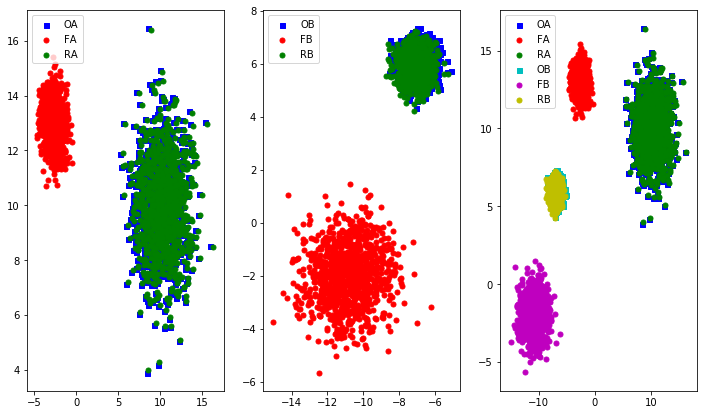

[Epoch 50/1000] [Batch 248/250] [D loss: 0.679534, acc:  31%] [Translation AB Dist: 1.748763 BA Dist: 4.556692 Min AB Dist: 1.483076 Max BA: 7.916898][G loss: 1.795674, adv: 0.696189, recon: 0.109047, id: 12.833798] time: 0:00:33.306053 
[Fake A Mean: (8, 8) Fake A Var: 0 A Mean: (9, 10) A Var: 2 ]
[Fake B Mean: (-8, 8) Fake B Var: 1 B Mean: (-7, 5) B Var: 0 ]


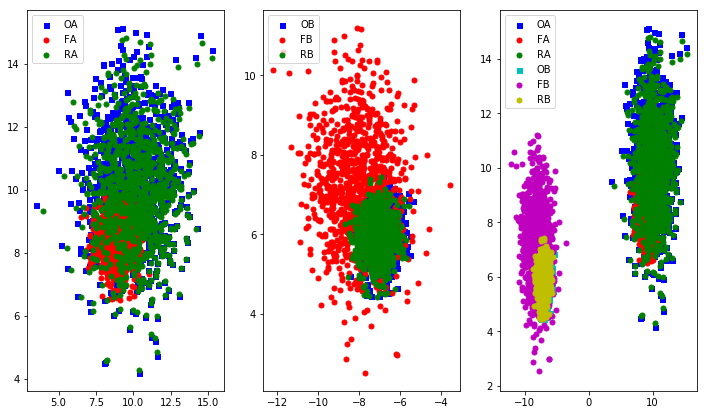

[Epoch 100/1000] [Batch 248/250] [D loss: 0.709606, acc:  18%] [Translation AB Dist: 0.557433 BA Dist: 3.933907 Min AB Dist: 0.381253 Max BA: 6.624102][G loss: 1.921319, adv: 0.653122, recon: 0.197320, id: 16.445839] time: 0:01:04.244700 
[Fake A Mean: (9, 9) Fake A Var: 0 A Mean: (10, 9) A Var: 2 ]
[Fake B Mean: (-7, 9) Fake B Var: 0 B Mean: (-7, 5) B Var: 0 ]


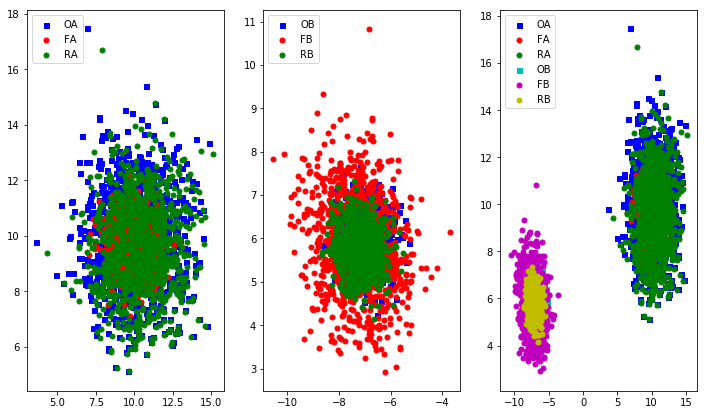

[Epoch 150/1000] [Batch 248/250] [D loss: 0.703747, acc:  31%] [Translation AB Dist: 0.603331 BA Dist: 4.003225 Min AB Dist: 0.447593 Max BA: 6.811190][G loss: 2.190481, adv: 0.676618, recon: 0.297362, id: 18.889774] time: 0:01:34.991755 
[Fake A Mean: (9, 9) Fake A Var: 0 A Mean: (10, 9) A Var: 2 ]
[Fake B Mean: (-7, 9) Fake B Var: 0 B Mean: (-6, 5) B Var: 0 ]


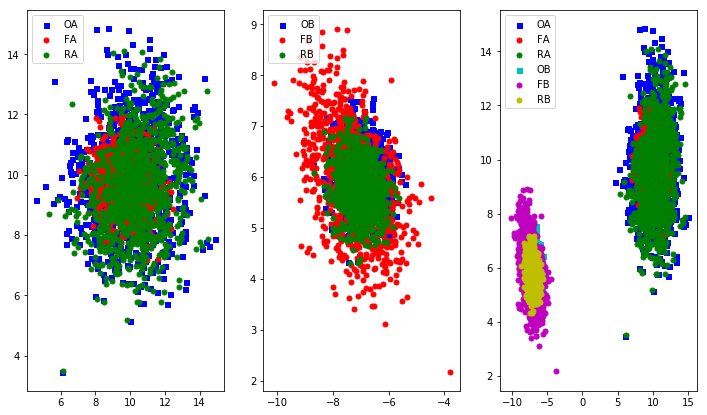

[Epoch 200/1000] [Batch 248/250] [D loss: 0.705784, acc:  31%] [Translation AB Dist: 0.580068 BA Dist: 4.030300 Min AB Dist: 0.432356 Max BA: 6.846787][G loss: 2.187780, adv: 0.674769, recon: 0.294987, id: 19.688496] time: 0:02:05.806533 
[Fake A Mean: (9, 9) Fake A Var: 1 A Mean: (9, 9) A Var: 2 ]
[Fake B Mean: (-7, 9) Fake B Var: 0 B Mean: (-7, 6) B Var: 0 ]


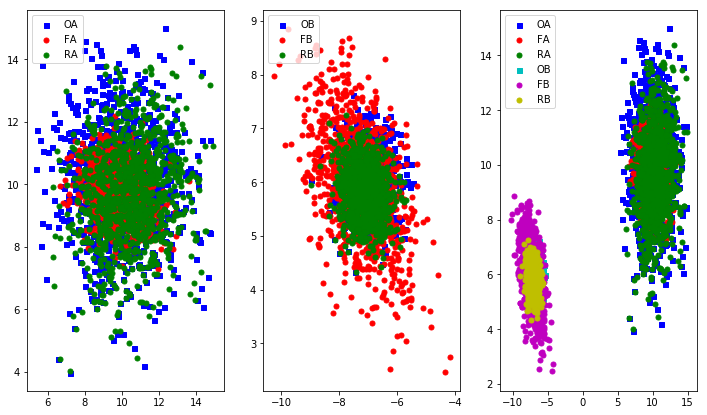

[Epoch 250/1000] [Batch 248/250] [D loss: 0.699858, acc:  31%] [Translation AB Dist: 0.611376 BA Dist: 4.081179 Min AB Dist: 0.472416 Max BA: 6.924799][G loss: 2.348151, adv: 0.687346, recon: 0.362981, id: 19.935146] time: 0:02:36.625659 
[Fake A Mean: (9, 9) Fake A Var: 1 A Mean: (10, 10) A Var: 2 ]
[Fake B Mean: (-7, 9) Fake B Var: 0 B Mean: (-6, 5) B Var: 0 ]


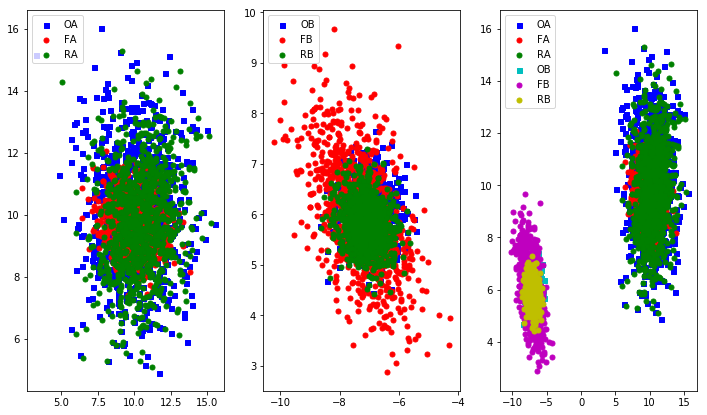

[Epoch 300/1000] [Batch 248/250] [D loss: 0.700180, acc:  31%] [Translation AB Dist: 0.593197 BA Dist: 4.082277 Min AB Dist: 0.449182 Max BA: 6.932032][G loss: 2.340970, adv: 0.685845, recon: 0.361420, id: 19.923080] time: 0:03:07.464239 
[Fake A Mean: (9, 9) Fake A Var: 1 A Mean: (10, 9) A Var: 2 ]
[Fake B Mean: (-7, 9) Fake B Var: 0 B Mean: (-7, 6) B Var: 0 ]


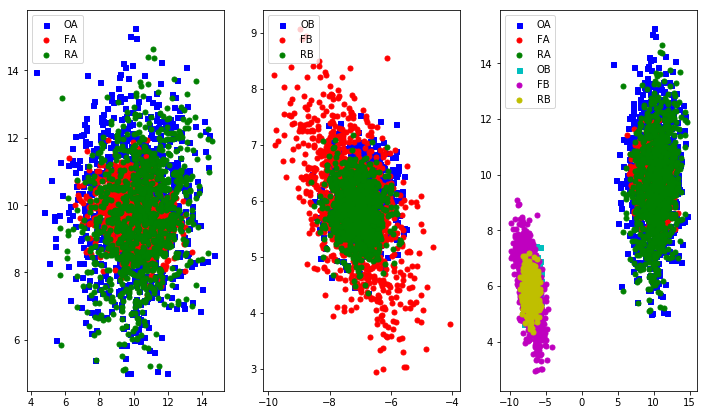

[Epoch 350/1000] [Batch 248/250] [D loss: 0.706427, acc:  31%] [Translation AB Dist: 0.542709 BA Dist: 4.056975 Min AB Dist: 0.405148 Max BA: 6.905674][G loss: 2.212322, adv: 0.674698, recon: 0.308947, id: 19.828510] time: 0:03:38.341529 
[Fake A Mean: (9, 9) Fake A Var: 1 A Mean: (10, 10) A Var: 2 ]
[Fake B Mean: (-7, 9) Fake B Var: 0 B Mean: (-6, 6) B Var: 0 ]


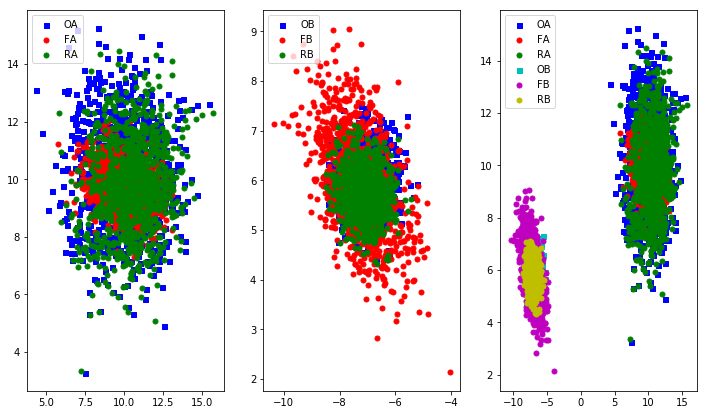

[Epoch 400/1000] [Batch 248/250] [D loss: 0.698600, acc:  31%] [Translation AB Dist: 0.614739 BA Dist: 4.082492 Min AB Dist: 0.479887 Max BA: 6.936760][G loss: 2.338510, adv: 0.689079, recon: 0.358317, id: 19.669132] time: 0:04:09.158345 
[Fake A Mean: (9, 9) Fake A Var: 1 A Mean: (9, 10) A Var: 3 ]
[Fake B Mean: (-7, 9) Fake B Var: 0 B Mean: (-6, 5) B Var: 0 ]


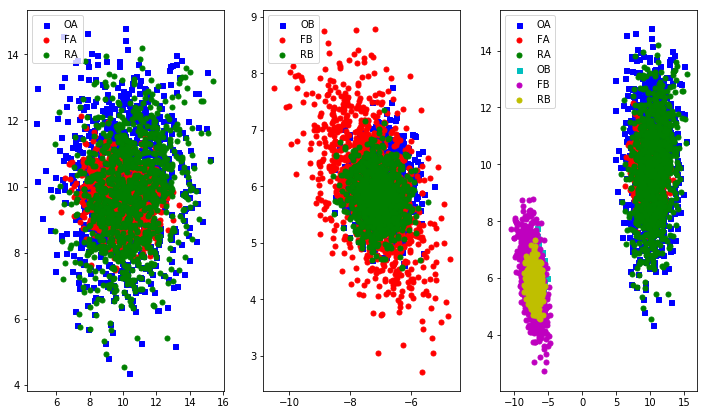

[Epoch 450/1000] [Batch 248/250] [D loss: 0.704301, acc:  31%] [Translation AB Dist: 0.620185 BA Dist: 4.088877 Min AB Dist: 0.456855 Max BA: 6.956998][G loss: 2.244053, adv: 0.677795, recon: 0.323319, id: 19.492300] time: 0:04:40.119574 
[Fake A Mean: (9, 9) Fake A Var: 1 A Mean: (9, 10) A Var: 2 ]
[Fake B Mean: (-7, 9) Fake B Var: 0 B Mean: (-6, 6) B Var: 0 ]


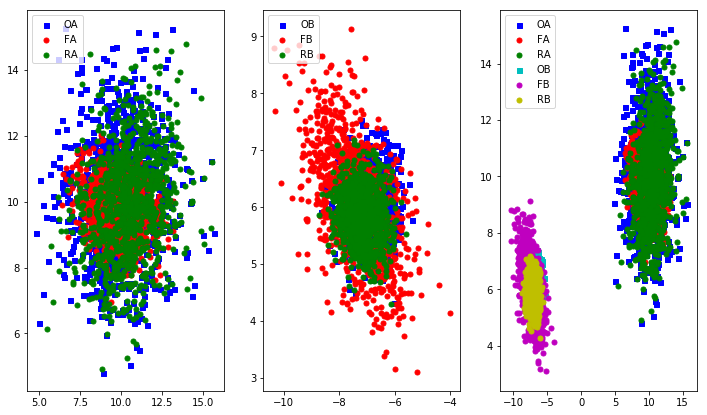

[Epoch 500/1000] [Batch 248/250] [D loss: 0.700621, acc:  31%] [Translation AB Dist: 0.596547 BA Dist: 4.062402 Min AB Dist: 0.461932 Max BA: 6.920332][G loss: 2.300044, adv: 0.683986, recon: 0.345497, id: 19.426907] time: 0:05:10.898805 
[Fake A Mean: (9, 9) Fake A Var: 1 A Mean: (10, 9) A Var: 2 ]
[Fake B Mean: (-7, 9) Fake B Var: 0 B Mean: (-6, 6) B Var: 0 ]


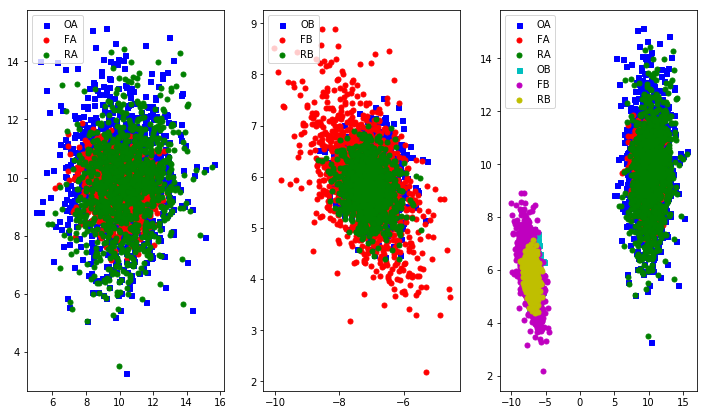

[Epoch 550/1000] [Batch 248/250] [D loss: 0.733195, acc:  31%] [Translation AB Dist: 0.482042 BA Dist: 3.993995 Min AB Dist: 0.297498 Max BA: 6.838454][G loss: 1.847762, adv: 0.623634, recon: 0.180496, id: 19.281303] time: 0:05:41.838929 
[Fake A Mean: (9, 9) Fake A Var: 1 A Mean: (9, 10) A Var: 3 ]
[Fake B Mean: (-6, 9) Fake B Var: 0 B Mean: (-7, 5) B Var: 0 ]


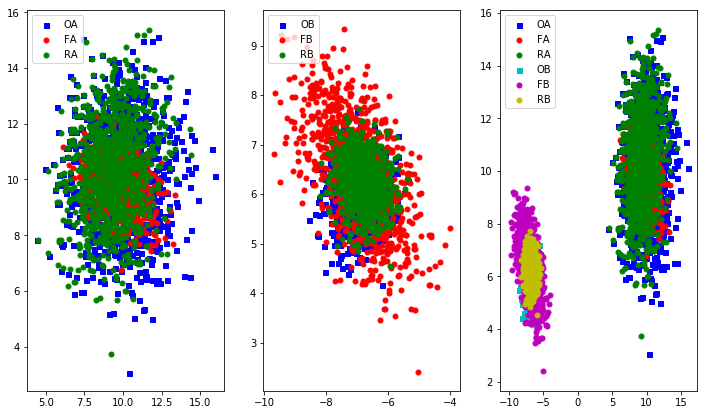

[Epoch 600/1000] [Batch 248/250] [D loss: 0.690087, acc:  43%] [Translation AB Dist: 0.735568 BA Dist: 4.105326 Min AB Dist: 0.564996 Max BA: 7.010430][G loss: 2.314796, adv: 0.723277, recon: 0.315133, id: 19.152273] time: 0:06:12.739089 
[Fake A Mean: (9, 9) Fake A Var: 1 A Mean: (9, 9) A Var: 2 ]
[Fake B Mean: (-7, 9) Fake B Var: 0 B Mean: (-7, 5) B Var: 0 ]


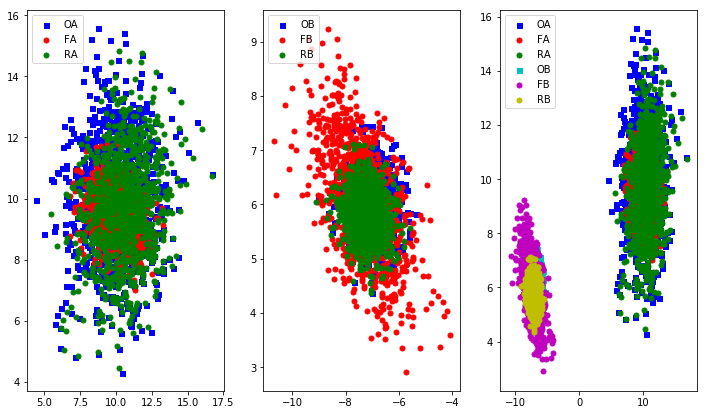

[Epoch 650/1000] [Batch 248/250] [D loss: 0.705585, acc:  50%] [Translation AB Dist: 0.587225 BA Dist: 4.024371 Min AB Dist: 0.445157 Max BA: 6.909565][G loss: 2.108382, adv: 0.698096, recon: 0.237099, id: 19.067041] time: 0:06:43.658568 
[Fake A Mean: (9, 9) Fake A Var: 1 A Mean: (9, 10) A Var: 2 ]
[Fake B Mean: (-7, 9) Fake B Var: 0 B Mean: (-6, 5) B Var: 0 ]


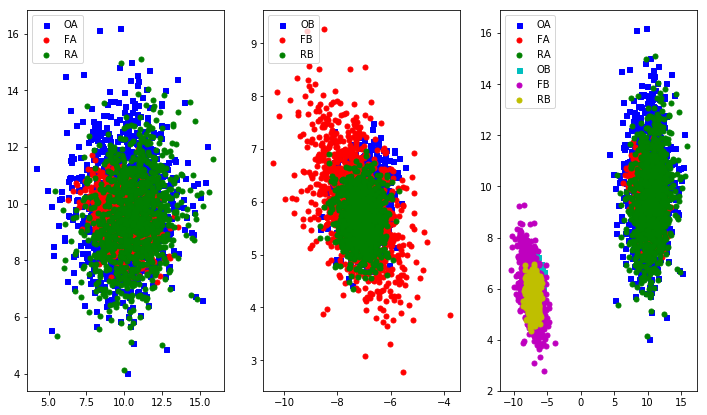

[Epoch 700/1000] [Batch 248/250] [D loss: 0.699732, acc:  56%] [Translation AB Dist: 0.640243 BA Dist: 4.057635 Min AB Dist: 0.497316 Max BA: 6.922213][G loss: 2.315078, adv: 0.714894, recon: 0.323621, id: 19.142475] time: 0:07:14.443365 
[Fake A Mean: (9, 9) Fake A Var: 1 A Mean: (10, 10) A Var: 3 ]
[Fake B Mean: (-7, 9) Fake B Var: 0 B Mean: (-7, 5) B Var: 0 ]


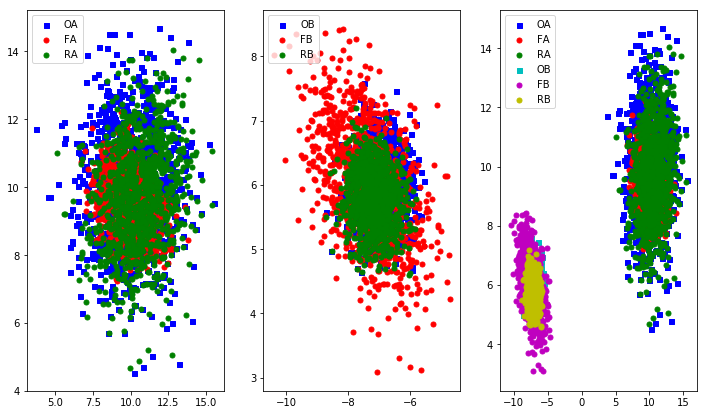

[Epoch 750/1000] [Batch 248/250] [D loss: 0.735980, acc:  43%] [Translation AB Dist: 0.445986 BA Dist: 3.946369 Min AB Dist: 0.249777 Max BA: 6.808377][G loss: 1.839166, adv: 0.642931, recon: 0.157955, id: 19.102623] time: 0:07:45.585095 
[Fake A Mean: (9, 9) Fake A Var: 1 A Mean: (9, 9) A Var: 3 ]
[Fake B Mean: (-7, 9) Fake B Var: 0 B Mean: (-6, 5) B Var: 0 ]


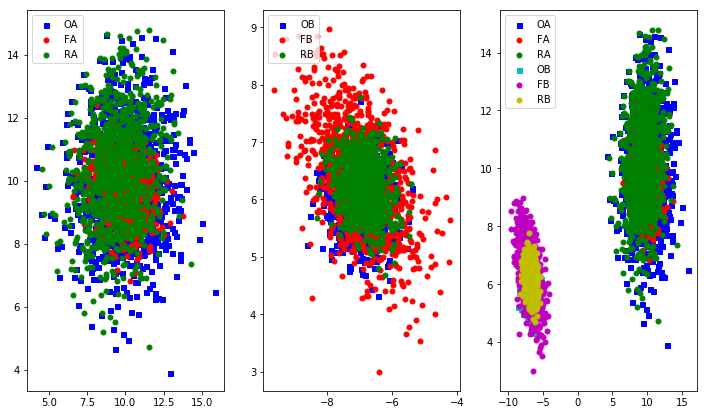

[Epoch 800/1000] [Batch 248/250] [D loss: 0.707965, acc:  56%] [Translation AB Dist: 0.549676 BA Dist: 4.006081 Min AB Dist: 0.430838 Max BA: 6.872985][G loss: 2.164796, adv: 0.700925, recon: 0.262929, id: 19.067883] time: 0:08:16.392946 
[Fake A Mean: (9, 9) Fake A Var: 1 A Mean: (10, 10) A Var: 2 ]
[Fake B Mean: (-7, 9) Fake B Var: 0 B Mean: (-7, 5) B Var: 0 ]


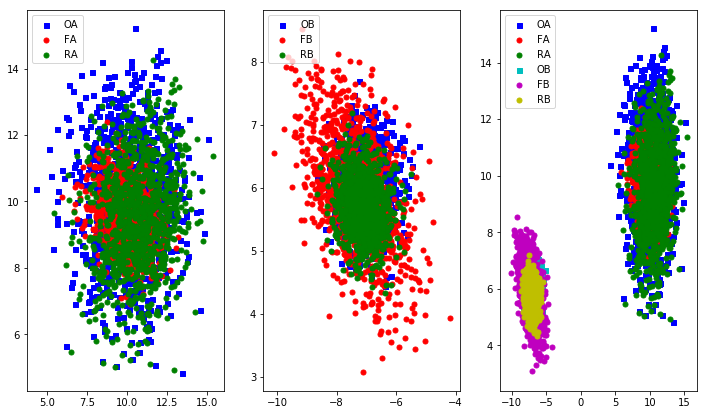

[Epoch 850/1000] [Batch 248/250] [D loss: 0.706647, acc:  56%] [Translation AB Dist: 0.578242 BA Dist: 4.011363 Min AB Dist: 0.448721 Max BA: 6.863934][G loss: 2.151551, adv: 0.703090, recon: 0.254615, id: 18.979584] time: 0:08:47.430752 
[Fake A Mean: (9, 9) Fake A Var: 1 A Mean: (10, 9) A Var: 3 ]
[Fake B Mean: (-7, 9) Fake B Var: 1 B Mean: (-7, 6) B Var: 0 ]


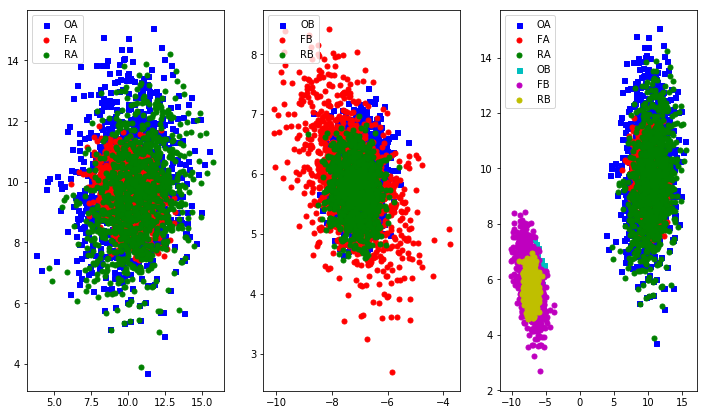

[Epoch 900/1000] [Batch 248/250] [D loss: 0.735187, acc:  43%] [Translation AB Dist: 0.469210 BA Dist: 3.946039 Min AB Dist: 0.295937 Max BA: 6.774674][G loss: 2.043538, adv: 0.643417, recon: 0.261049, id: 18.806501] time: 0:09:18.299301 
[Fake A Mean: (9, 9) Fake A Var: 1 A Mean: (9, 10) A Var: 2 ]
[Fake B Mean: (-6, 9) Fake B Var: 0 B Mean: (-6, 6) B Var: 0 ]


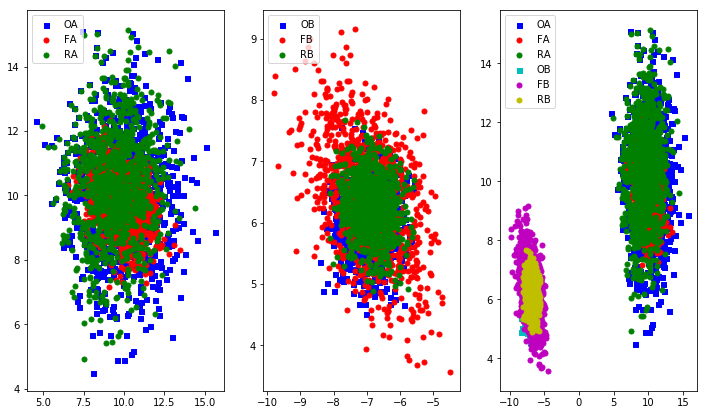

[Epoch 950/1000] [Batch 248/250] [D loss: 0.705185, acc:  56%] [Translation AB Dist: 0.568471 BA Dist: 4.010444 Min AB Dist: 0.447428 Max BA: 6.850737][G loss: 2.244953, adv: 0.705600, recon: 0.299936, id: 18.750790] time: 0:09:49.254605 
[Fake A Mean: (9, 9) Fake A Var: 1 A Mean: (9, 10) A Var: 3 ]
[Fake B Mean: (-7, 9) Fake B Var: 0 B Mean: (-6, 5) B Var: 0 ]


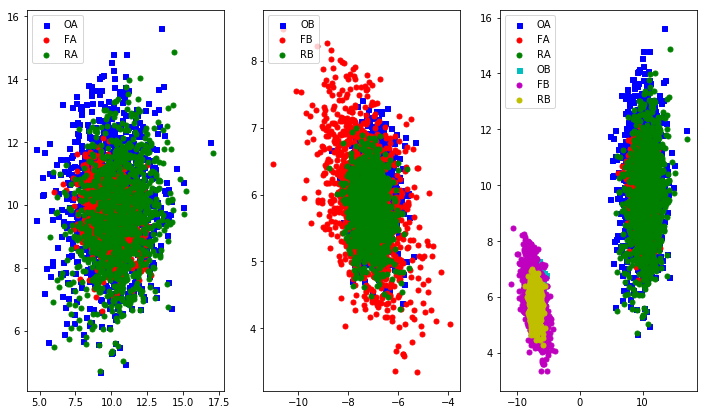

In [82]:
gan_default= CycleGAN(data_A, data_B)
gan_default.train(epochs=1000, batch_size=4, sample_interval=50)

Increased the discriminator loss to 5x what it is normally (not 2x!)

[Epoch 0/1000] [Batch 248/250] [D loss: 0.680681, acc:  50%] 
  [Translation AB Dist: 5.937490 BA Dist: 9.666752 Min AB Dist: 5.742973 Max AB: 6.177390 Min BA: 7.796417Max BA: 11.594579] 
 [G loss: 15.144483, adv: 0.846380, recon: 3.253121, id: 14.105005] time: 0:00:02.126762 
[Fake A Mean: (2, 16) Fake A Var: 0 A Mean: (10, 10) A Var: 2 ]
[Fake B Mean: (-1, 16) Fake B Var: 1 B Mean: (-7, 6) B Var: 0 ]


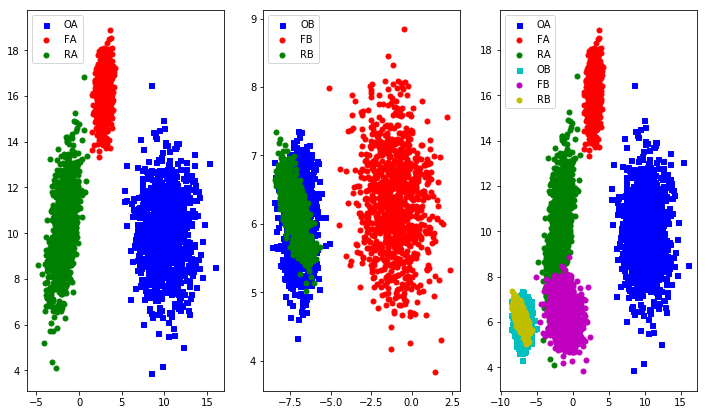

[Epoch 50/1000] [Batch 248/250] [D loss: 0.693668, acc:   0%] 
  [Translation AB Dist: 6.293559 BA Dist: 7.294563 Min AB Dist: 5.944800 Max AB: 6.631509 Min BA: 4.669465Max BA: 11.540390] 
 [G loss: 7.418731, adv: 0.693075, recon: 0.162458, id: 9.308738] time: 0:00:33.057511 
[Fake A Mean: (7, 4) Fake A Var: 0 A Mean: (9, 10) A Var: 2 ]
[Fake B Mean: (-8, 4) Fake B Var: 2 B Mean: (-7, 5) B Var: 0 ]


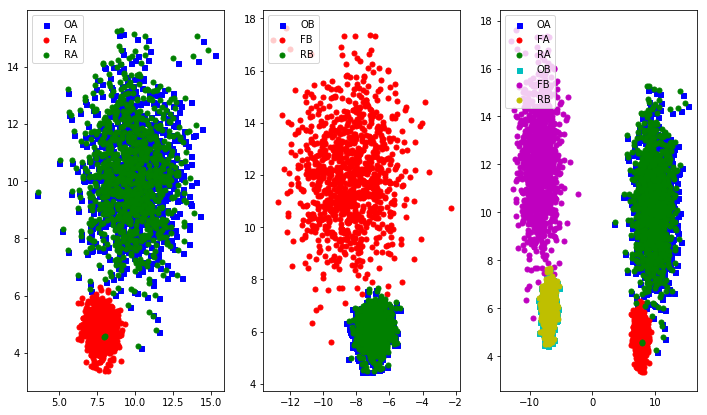

[Epoch 100/1000] [Batch 248/250] [D loss: 0.693508, acc:   0%] 
  [Translation AB Dist: 5.609009 BA Dist: 6.812408 Min AB Dist: 5.278252 Max AB: 5.916086 Min BA: 4.030575Max BA: 10.980654] 
 [G loss: 7.387826, adv: 0.693253, recon: 0.147173, id: 8.533710] time: 0:01:03.823383 
[Fake A Mean: (7, 5) Fake A Var: 0 A Mean: (10, 9) A Var: 2 ]
[Fake B Mean: (-8, 5) Fake B Var: 3 B Mean: (-7, 5) B Var: 0 ]


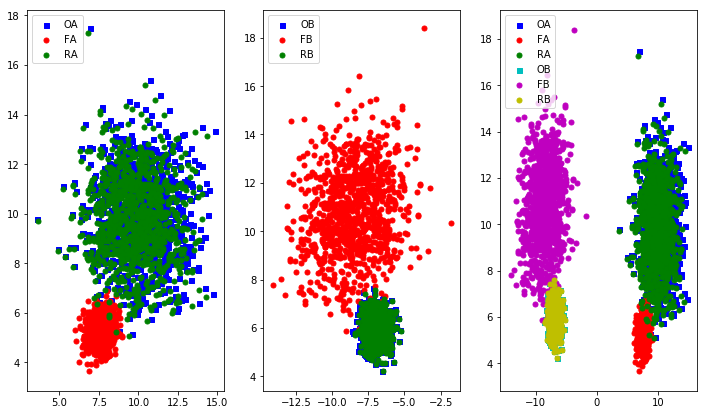

[Epoch 150/1000] [Batch 248/250] [D loss: 0.693470, acc:   0%] 
  [Translation AB Dist: 5.164452 BA Dist: 6.598279 Min AB Dist: 4.846802 Max AB: 5.442855 Min BA: 3.684235Max BA: 10.777521] 
 [G loss: 7.396761, adv: 0.693277, recon: 0.151518, id: 8.479326] time: 0:01:34.704050 
[Fake A Mean: (7, 5) Fake A Var: 0 A Mean: (10, 9) A Var: 2 ]
[Fake B Mean: (-8, 5) Fake B Var: 3 B Mean: (-6, 5) B Var: 0 ]


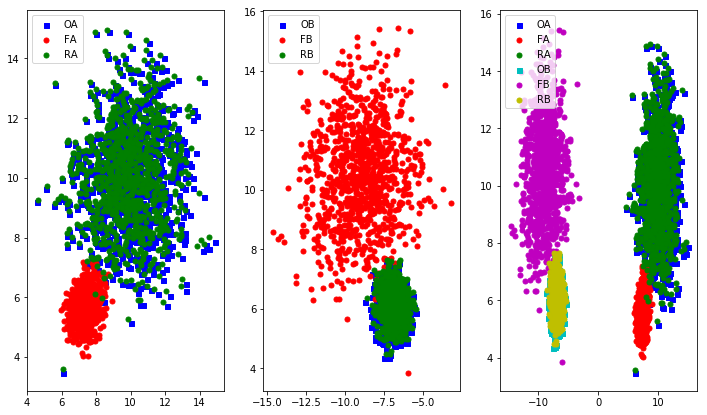

[Epoch 200/1000] [Batch 248/250] [D loss: 0.693450, acc:   0%] 
  [Translation AB Dist: 5.106397 BA Dist: 6.587361 Min AB Dist: 4.795726 Max AB: 5.369095 Min BA: 3.497994Max BA: 10.788954] 
 [G loss: 7.323518, adv: 0.693296, recon: 0.114623, id: 8.581285] time: 0:02:05.513987 
[Fake A Mean: (7, 5) Fake A Var: 0 A Mean: (9, 9) A Var: 2 ]
[Fake B Mean: (-9, 5) Fake B Var: 3 B Mean: (-7, 6) B Var: 0 ]


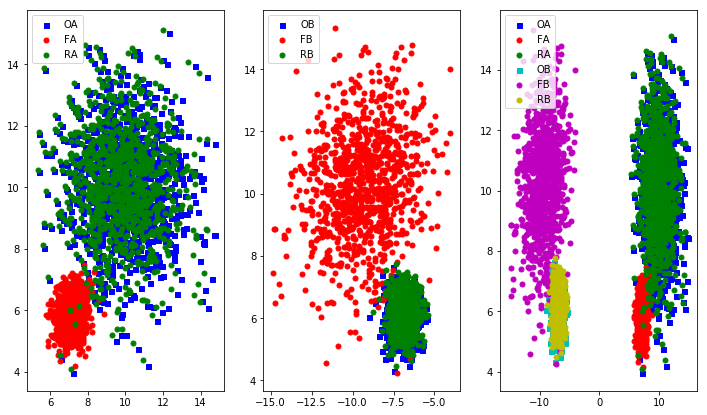

[Epoch 250/1000] [Batch 248/250] [D loss: 0.693435, acc:   0%] 
  [Translation AB Dist: 5.258740 BA Dist: 6.652588 Min AB Dist: 4.952123 Max AB: 5.511879 Min BA: 3.416592Max BA: 10.856291] 
 [G loss: 7.376215, adv: 0.693304, recon: 0.140393, id: 8.763187] time: 0:02:36.270781 
[Fake A Mean: (6, 5) Fake A Var: 0 A Mean: (10, 10) A Var: 2 ]
[Fake B Mean: (-9, 5) Fake B Var: 3 B Mean: (-6, 5) B Var: 0 ]


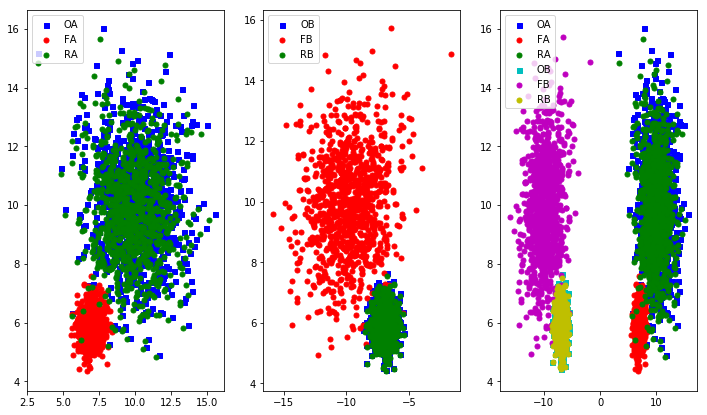

[Epoch 300/1000] [Batch 248/250] [D loss: 0.693431, acc:   0%] 
  [Translation AB Dist: 5.214186 BA Dist: 6.676160 Min AB Dist: 4.916951 Max AB: 5.451585 Min BA: 3.308729Max BA: 10.919501] 
 [G loss: 7.394431, adv: 0.693307, recon: 0.149486, id: 8.899158] time: 0:03:06.774327 
[Fake A Mean: (6, 6) Fake A Var: 0 A Mean: (10, 9) A Var: 2 ]
[Fake B Mean: (-10, 6) Fake B Var: 3 B Mean: (-7, 6) B Var: 0 ]


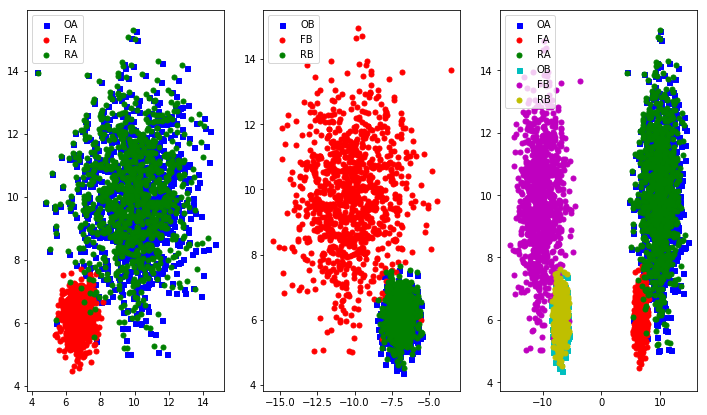

[Epoch 350/1000] [Batch 248/250] [D loss: 0.693432, acc:   0%] 
  [Translation AB Dist: 5.308627 BA Dist: 6.798055 Min AB Dist: 5.013451 Max AB: 5.542916 Min BA: 3.207622Max BA: 11.100961] 
 [G loss: 7.410890, adv: 0.693310, recon: 0.157310, id: 9.120965] time: 0:03:37.435920 
[Fake A Mean: (6, 6) Fake A Var: 0 A Mean: (10, 10) A Var: 2 ]
[Fake B Mean: (-10, 6) Fake B Var: 3 B Mean: (-6, 6) B Var: 0 ]


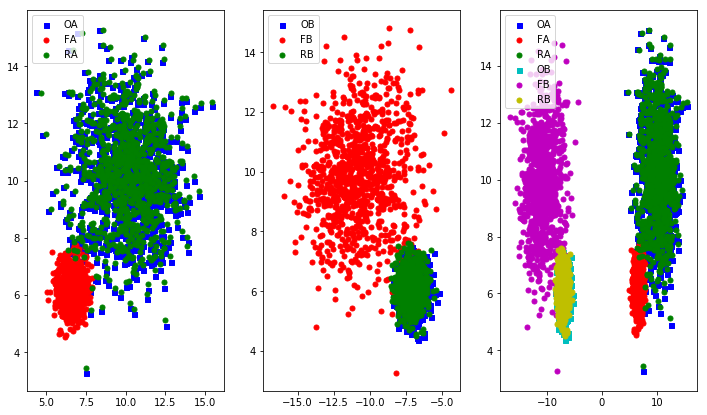

[Epoch 400/1000] [Batch 248/250] [D loss: 0.693431, acc:  12%] 
  [Translation AB Dist: 5.391937 BA Dist: 6.844161 Min AB Dist: 5.103254 Max AB: 5.616413 Min BA: 3.138316Max BA: 11.158137] 
 [G loss: 7.336380, adv: 0.693310, recon: 0.119477, id: 9.342356] time: 0:04:07.922280 
[Fake A Mean: (6, 6) Fake A Var: 0 A Mean: (9, 10) A Var: 3 ]
[Fake B Mean: (-11, 6) Fake B Var: 3 B Mean: (-6, 5) B Var: 0 ]


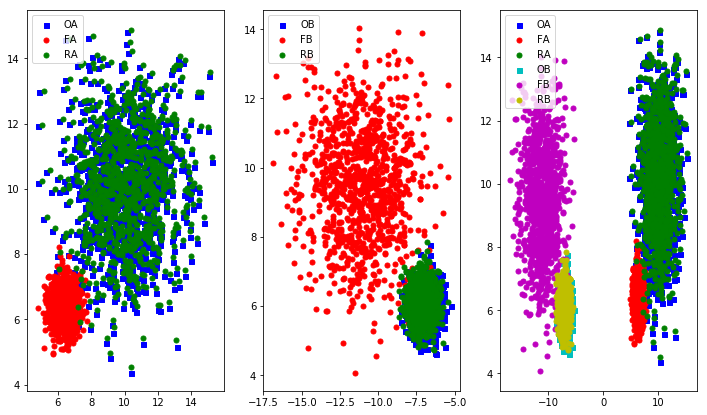

[Epoch 450/1000] [Batch 248/250] [D loss: 0.693401, acc:  18%] 
  [Translation AB Dist: 5.414176 BA Dist: 6.871243 Min AB Dist: 5.131782 Max AB: 5.630355 Min BA: 3.045308Max BA: 11.202487] 
 [G loss: 7.395832, adv: 0.693333, recon: 0.148814, id: 9.498997] time: 0:04:38.607348 
[Fake A Mean: (6, 6) Fake A Var: 0 A Mean: (9, 10) A Var: 2 ]
[Fake B Mean: (-11, 6) Fake B Var: 3 B Mean: (-6, 6) B Var: 0 ]


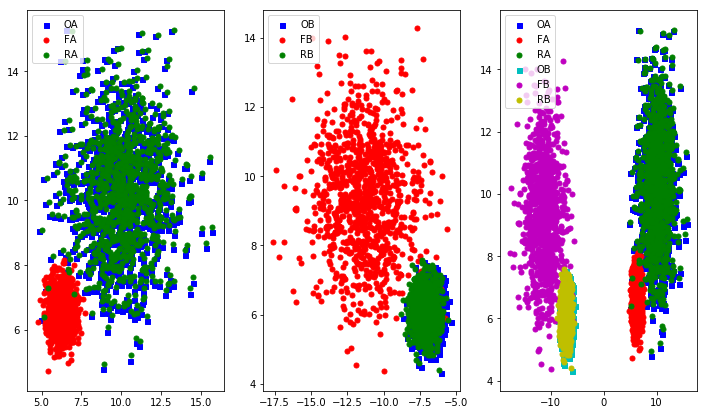

[Epoch 500/1000] [Batch 248/250] [D loss: 0.692887, acc:  50%] 
  [Translation AB Dist: 5.414971 BA Dist: 6.815536 Min AB Dist: 5.140636 Max AB: 5.620419 Min BA: 2.981515Max BA: 11.113388] 
 [G loss: 7.381042, adv: 0.693597, recon: 0.140009, id: 9.557280] time: 0:05:09.161596 
[Fake A Mean: (6, 6) Fake A Var: 0 A Mean: (10, 9) A Var: 2 ]
[Fake B Mean: (-11, 6) Fake B Var: 3 B Mean: (-6, 6) B Var: 0 ]


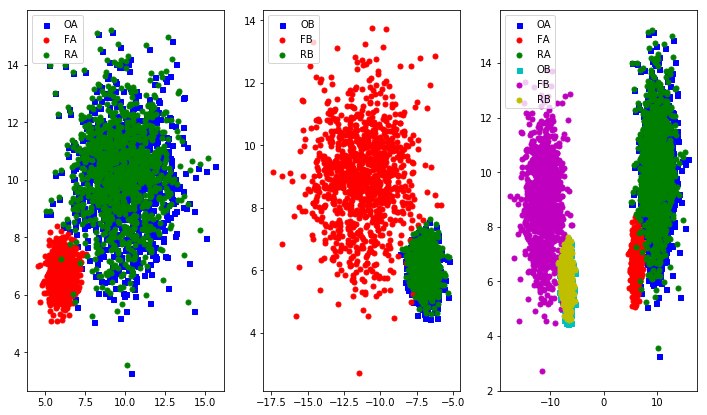

[Epoch 550/1000] [Batch 248/250] [D loss: 0.695971, acc:  18%] 
  [Translation AB Dist: 1.334517 BA Dist: 4.437353 Min AB Dist: 1.106542 Max AB: 1.511591 Min BA: 2.615201Max BA: 7.557264] 
 [G loss: 7.144505, adv: 0.672805, recon: 0.108497, id: 14.454113] time: 0:05:39.983940 
[Fake A Mean: (8, 9) Fake A Var: 0 A Mean: (9, 10) A Var: 3 ]
[Fake B Mean: (-7, 9) Fake B Var: 1 B Mean: (-7, 5) B Var: 0 ]


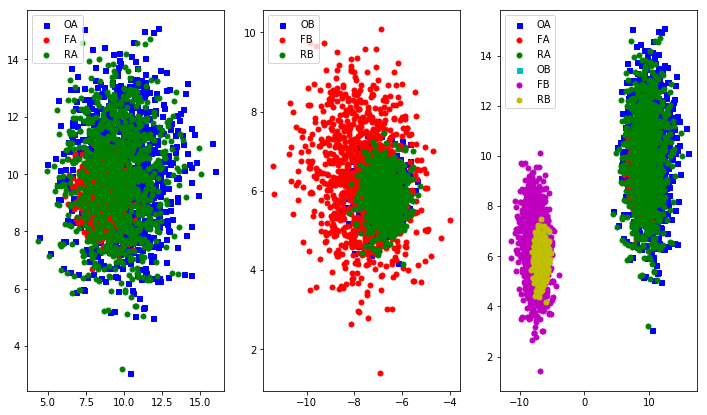

[Epoch 600/1000] [Batch 248/250] [D loss: 0.712742, acc:  18%] 
  [Translation AB Dist: 0.574367 BA Dist: 4.120502 Min AB Dist: 0.380749 Max AB: 0.783941 Min BA: 2.906737Max BA: 7.021894] 
 [G loss: 7.427692, adv: 0.660005, recon: 0.287302, id: 20.705202] time: 0:06:10.724191 
[Fake A Mean: (9, 9) Fake A Var: 1 A Mean: (9, 9) A Var: 2 ]
[Fake B Mean: (-7, 9) Fake B Var: 0 B Mean: (-7, 5) B Var: 0 ]


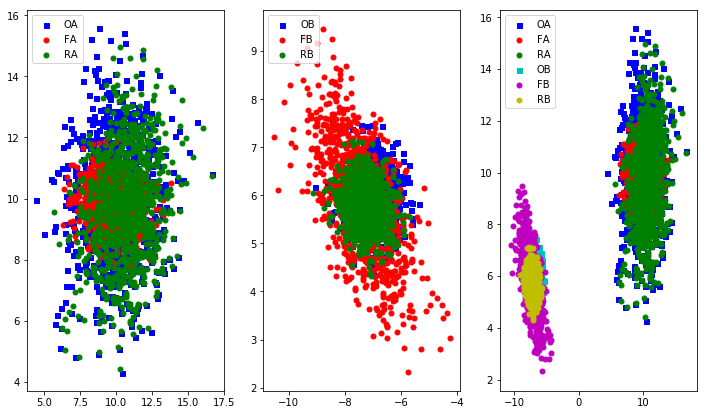

[Epoch 650/1000] [Batch 248/250] [D loss: 0.701624, acc:  31%] 
  [Translation AB Dist: 0.575516 BA Dist: 4.176297 Min AB Dist: 0.410615 Max AB: 0.766872 Min BA: 2.969673Max BA: 7.103444] 
 [G loss: 7.949035, adv: 0.688857, recon: 0.393265, id: 23.089441] time: 0:06:41.553928 
[Fake A Mean: (9, 9) Fake A Var: 1 A Mean: (9, 10) A Var: 2 ]
[Fake B Mean: (-7, 9) Fake B Var: 0 B Mean: (-6, 5) B Var: 0 ]


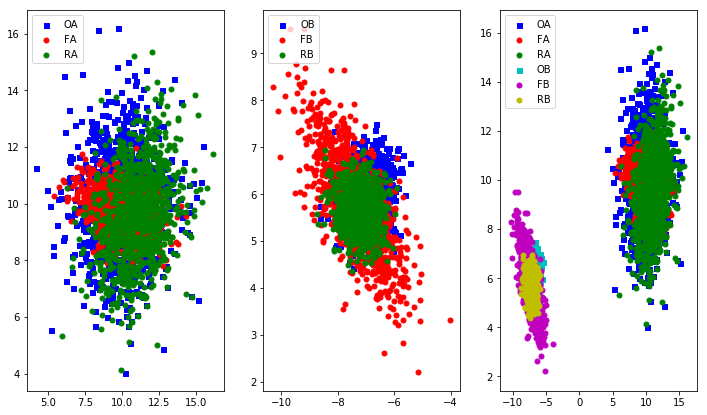

[Epoch 700/1000] [Batch 248/250] [D loss: 0.716011, acc:  12%] 
  [Translation AB Dist: 0.494307 BA Dist: 4.108201 Min AB Dist: 0.307500 Max AB: 0.686835 Min BA: 2.832074Max BA: 7.059079] 
 [G loss: 7.265280, adv: 0.653365, recon: 0.228601, id: 23.181498] time: 0:07:12.283349 
[Fake A Mean: (9, 9) Fake A Var: 1 A Mean: (10, 10) A Var: 3 ]
[Fake B Mean: (-6, 9) Fake B Var: 0 B Mean: (-7, 5) B Var: 0 ]


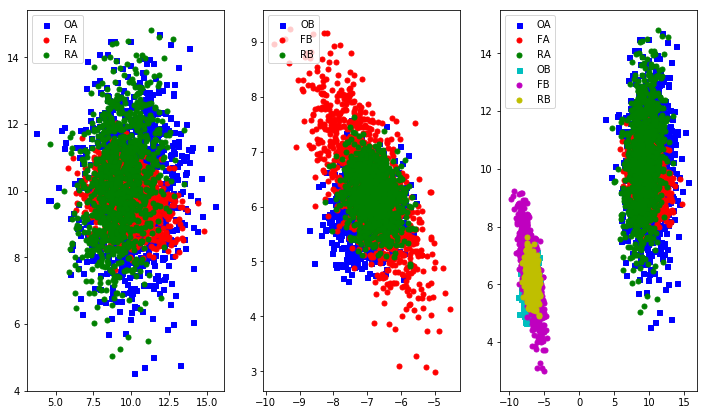

[Epoch 750/1000] [Batch 248/250] [D loss: 0.688754, acc:  25%] 
  [Translation AB Dist: 0.619587 BA Dist: 4.178281 Min AB Dist: 0.475495 Max AB: 0.819088 Min BA: 2.914581Max BA: 7.142505] 
 [G loss: 7.972314, adv: 0.701290, recon: 0.343986, id: 22.864689] time: 0:07:43.138030 
[Fake A Mean: (9, 9) Fake A Var: 1 A Mean: (9, 9) A Var: 3 ]
[Fake B Mean: (-7, 9) Fake B Var: 0 B Mean: (-6, 5) B Var: 0 ]


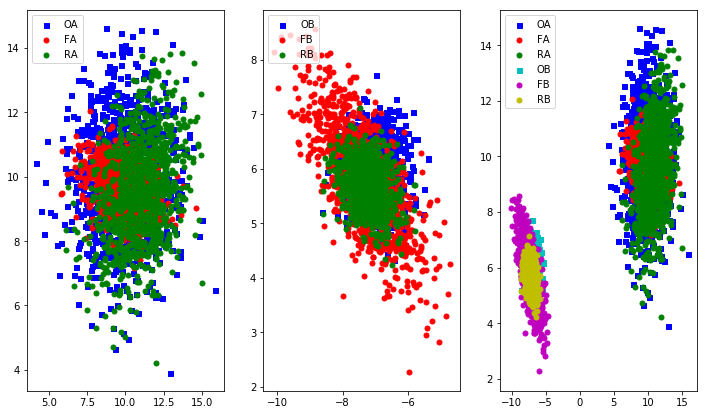

[Epoch 800/1000] [Batch 248/250] [D loss: 0.684587, acc:  31%] 
  [Translation AB Dist: 0.641528 BA Dist: 4.186552 Min AB Dist: 0.497408 Max AB: 0.832670 Min BA: 2.909230Max BA: 7.161298] 
 [G loss: 8.155838, adv: 0.709162, recon: 0.396440, id: 22.850193] time: 0:08:13.861040 
[Fake A Mean: (9, 9) Fake A Var: 1 A Mean: (10, 10) A Var: 2 ]
[Fake B Mean: (-7, 9) Fake B Var: 0 B Mean: (-7, 5) B Var: 0 ]


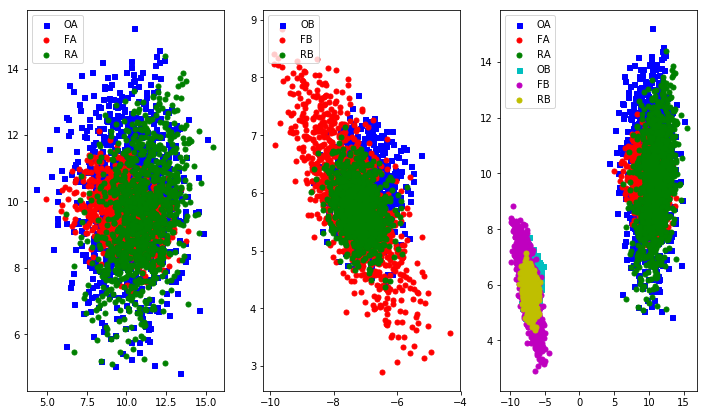

[Epoch 850/1000] [Batch 248/250] [D loss: 0.706391, acc:  12%] 
  [Translation AB Dist: 0.479811 BA Dist: 4.089071 Min AB Dist: 0.256355 Max AB: 0.689083 Min BA: 2.791834Max BA: 7.063655] 
 [G loss: 7.206872, adv: 0.665107, recon: 0.143152, id: 22.655264] time: 0:08:44.810301 
[Fake A Mean: (9, 9) Fake A Var: 1 A Mean: (10, 9) A Var: 3 ]
[Fake B Mean: (-7, 9) Fake B Var: 0 B Mean: (-7, 6) B Var: 0 ]


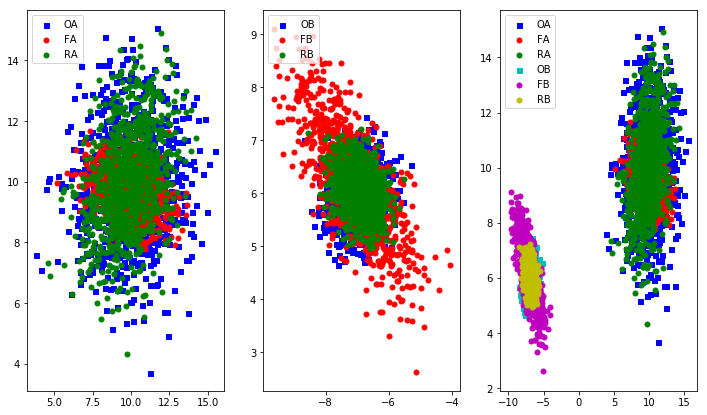

[Epoch 900/1000] [Batch 248/250] [D loss: 0.679674, acc:  31%] 
  [Translation AB Dist: 0.696936 BA Dist: 4.200361 Min AB Dist: 0.558432 Max AB: 0.886202 Min BA: 2.912017Max BA: 7.181191] 
 [G loss: 8.299257, adv: 0.715503, recon: 0.439009, id: 22.332317] time: 0:09:15.638320 
[Fake A Mean: (9, 9) Fake A Var: 1 A Mean: (9, 10) A Var: 2 ]
[Fake B Mean: (-7, 9) Fake B Var: 0 B Mean: (-6, 6) B Var: 0 ]


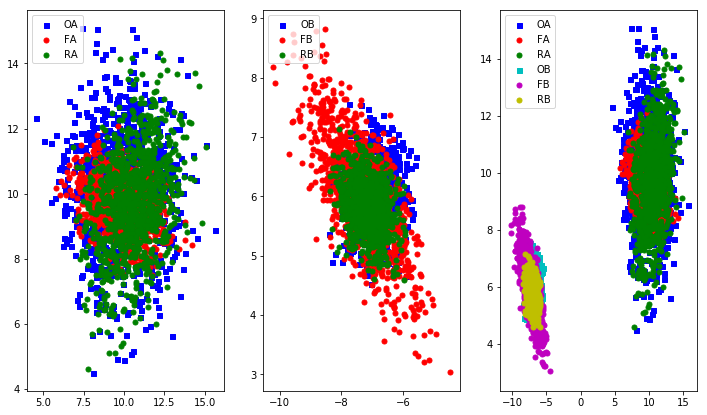

[Epoch 950/1000] [Batch 248/250] [D loss: 0.677583, acc:  37%] 
  [Translation AB Dist: 0.714011 BA Dist: 4.197101 Min AB Dist: 0.578463 Max AB: 0.895938 Min BA: 2.929497Max BA: 7.139055] 
 [G loss: 8.384254, adv: 0.717811, recon: 0.470864, id: 22.158792] time: 0:09:46.519018 
[Fake A Mean: (9, 9) Fake A Var: 1 A Mean: (9, 10) A Var: 3 ]
[Fake B Mean: (-7, 9) Fake B Var: 0 B Mean: (-6, 5) B Var: 0 ]


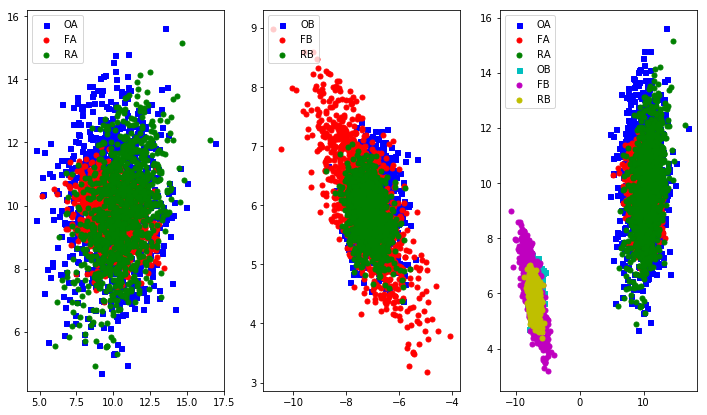

In [84]:
gan_2x_discloss = CycleGAN(data_A, data_B, disclossconst=5)
gan_2x_discloss.train(epochs=1000, batch_size=4, sample_interval=50)

[Epoch 0/1000] [Batch 248/250] [D loss: 0.840959, acc:  50%] 
  [Translation AB Dist: 10.720871 BA Dist: 13.058486 Min AB Dist: 10.472420 Max AB: 11.036798 Min BA: 10.957919Max BA: 15.064229] 
 [G loss: 19.663902, adv: 0.544075, recon: 4.317153, id: 11.144102] time: 0:00:02.691891 
[Fake A Mean: (0, 16) Fake A Var: 0 A Mean: (10, 10) A Var: 2 ]
[Fake B Mean: (3, 16) Fake B Var: 2 B Mean: (-7, 6) B Var: 0 ]


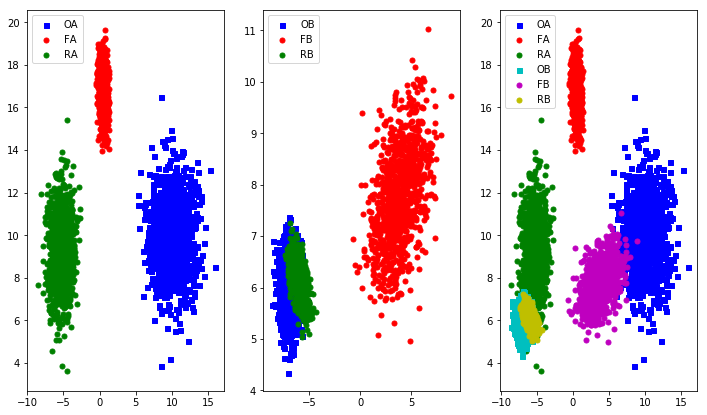

[Epoch 50/1000] [Batch 248/250] [D loss: 0.688817, acc:  31%] 
  [Translation AB Dist: 7.903833 BA Dist: 7.818795 Min AB Dist: 7.308565 Max AB: 8.591078 Min BA: 4.464807Max BA: 11.726796] 
 [G loss: 14.183765, adv: 0.690940, recon: 0.097236, id: 9.194599] time: 0:00:42.727040 
[Fake A Mean: (7, 5) Fake A Var: 0 A Mean: (9, 10) A Var: 2 ]
[Fake B Mean: (-13, 5) Fake B Var: 12 B Mean: (-7, 5) B Var: 0 ]


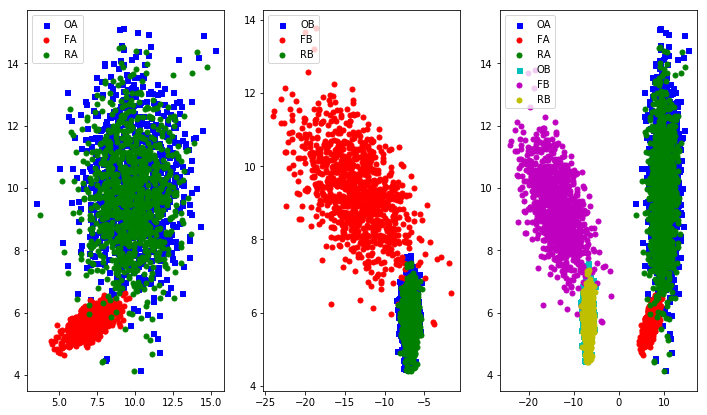

[Epoch 100/1000] [Batch 248/250] [D loss: 0.693419, acc:  25%] 
  [Translation AB Dist: 4.600064 BA Dist: 5.638273 Min AB Dist: 4.069962 Max AB: 5.120041 Min BA: 4.113304Max BA: 8.581500] 
 [G loss: 14.307116, adv: 0.694375, recon: 0.125742, id: 8.265215] time: 0:01:23.059504 
[Fake A Mean: (10, 7) Fake A Var: 0 A Mean: (10, 9) A Var: 2 ]
[Fake B Mean: (-10, 7) Fake B Var: 6 B Mean: (-7, 5) B Var: 0 ]


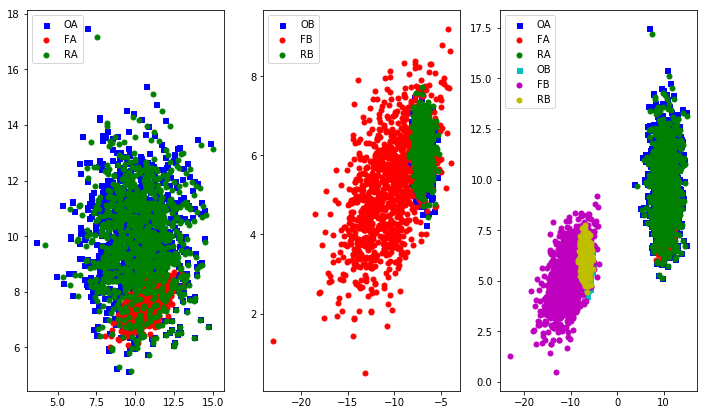

[Epoch 150/1000] [Batch 248/250] [D loss: 0.693128, acc:  31%] 
  [Translation AB Dist: 0.623626 BA Dist: 3.854599 Min AB Dist: 0.531295 Max AB: 0.751740 Min BA: 2.811149Max BA: 6.028511] 
 [G loss: 14.126566, adv: 0.692634, recon: 0.054388, id: 10.822128] time: 0:02:03.104903 
[Fake A Mean: (9, 10) Fake A Var: 0 A Mean: (10, 9) A Var: 2 ]
[Fake B Mean: (-6, 10) Fake B Var: 2 B Mean: (-6, 5) B Var: 0 ]


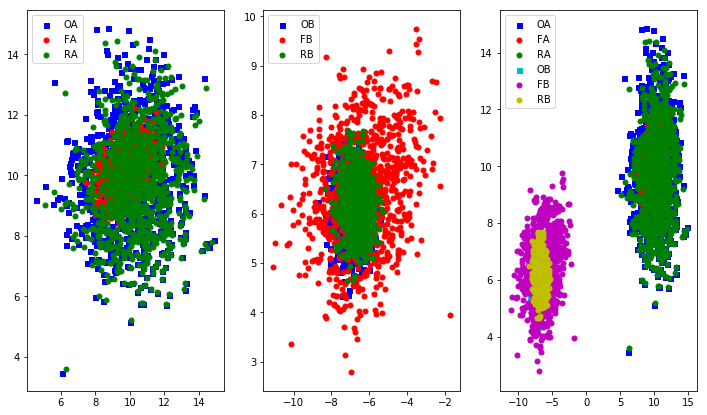

[Epoch 200/1000] [Batch 248/250] [D loss: 0.692689, acc:  37%] 
  [Translation AB Dist: 1.048602 BA Dist: 4.050889 Min AB Dist: 0.789797 Max AB: 1.277077 Min BA: 2.524974Max BA: 6.689034] 
 [G loss: 14.218704, adv: 0.692210, recon: 0.073438, id: 16.981119] time: 0:02:43.952931 
[Fake A Mean: (9, 9) Fake A Var: 0 A Mean: (9, 9) A Var: 2 ]
[Fake B Mean: (-7, 9) Fake B Var: 1 B Mean: (-7, 6) B Var: 0 ]


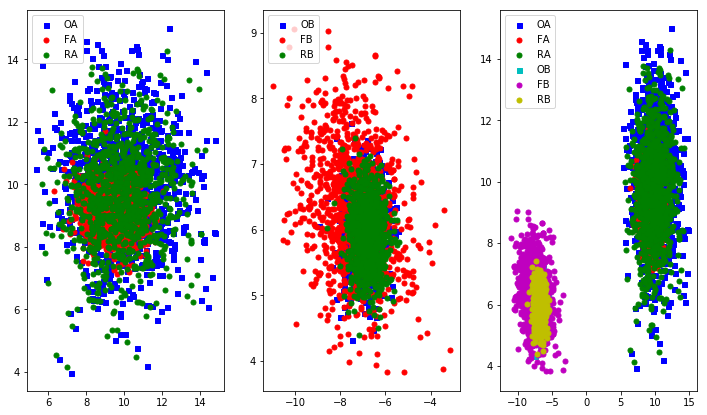

[Epoch 250/1000] [Batch 248/250] [D loss: 0.697331, acc:  12%] 
  [Translation AB Dist: 0.666135 BA Dist: 3.925240 Min AB Dist: 0.444751 Max AB: 0.854454 Min BA: 2.617450Max BA: 6.438013] 
 [G loss: 14.412886, adv: 0.691062, recon: 0.144865, id: 23.549479] time: 0:03:24.427042 
[Fake A Mean: (9, 9) Fake A Var: 0 A Mean: (10, 10) A Var: 2 ]
[Fake B Mean: (-7, 9) Fake B Var: 0 B Mean: (-6, 5) B Var: 0 ]


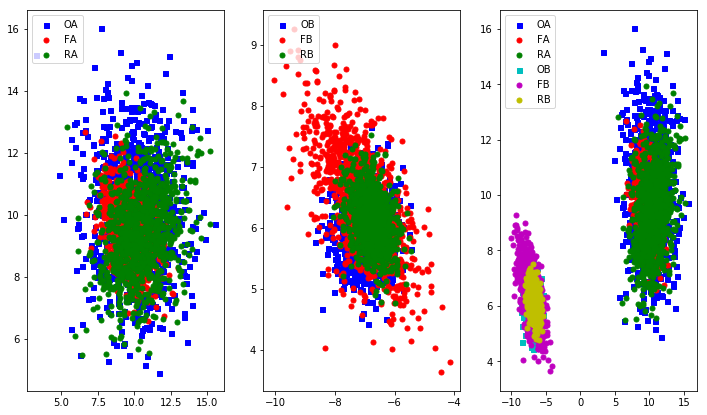

[Epoch 300/1000] [Batch 248/250] [D loss: 0.698238, acc:  18%] 
  [Translation AB Dist: 0.448190 BA Dist: 3.867807 Min AB Dist: 0.293971 Max AB: 0.591122 Min BA: 2.656800Max BA: 6.352452] 
 [G loss: 14.466080, adv: 0.689069, recon: 0.185554, id: 24.330286] time: 0:04:04.510757 
[Fake A Mean: (9, 9) Fake A Var: 0 A Mean: (10, 9) A Var: 2 ]
[Fake B Mean: (-7, 9) Fake B Var: 0 B Mean: (-7, 6) B Var: 0 ]


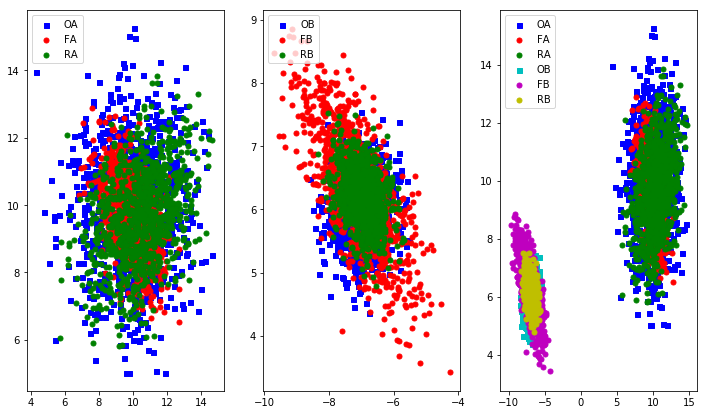

[Epoch 350/1000] [Batch 248/250] [D loss: 0.700066, acc:  18%] 
  [Translation AB Dist: 0.394544 BA Dist: 3.873687 Min AB Dist: 0.258777 Max AB: 0.513856 Min BA: 2.700941Max BA: 6.340946] 
 [G loss: 14.292093, adv: 0.685202, recon: 0.134922, id: 24.600771] time: 0:04:44.904278 
[Fake A Mean: (9, 9) Fake A Var: 0 A Mean: (10, 10) A Var: 2 ]
[Fake B Mean: (-7, 9) Fake B Var: 0 B Mean: (-6, 6) B Var: 0 ]


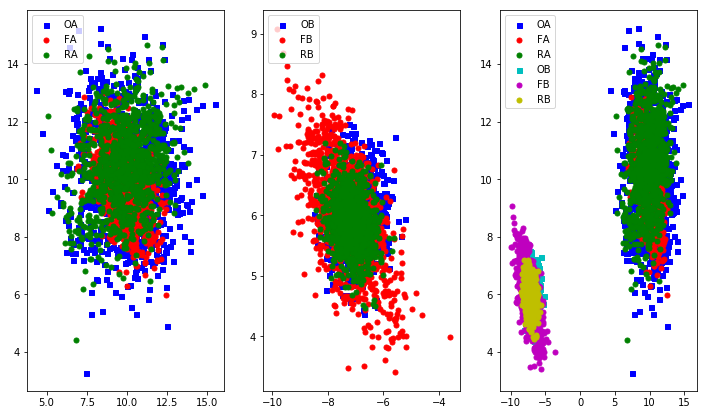

[Epoch 400/1000] [Batch 248/250] [D loss: 0.700324, acc:  18%] 
  [Translation AB Dist: 0.372769 BA Dist: 3.872925 Min AB Dist: 0.260607 Max AB: 0.480219 Min BA: 2.720888Max BA: 6.338593] 
 [G loss: 14.334743, adv: 0.685397, recon: 0.153787, id: 24.690701] time: 0:05:25.174103 
[Fake A Mean: (9, 9) Fake A Var: 0 A Mean: (9, 10) A Var: 3 ]
[Fake B Mean: (-7, 9) Fake B Var: 0 B Mean: (-6, 5) B Var: 0 ]


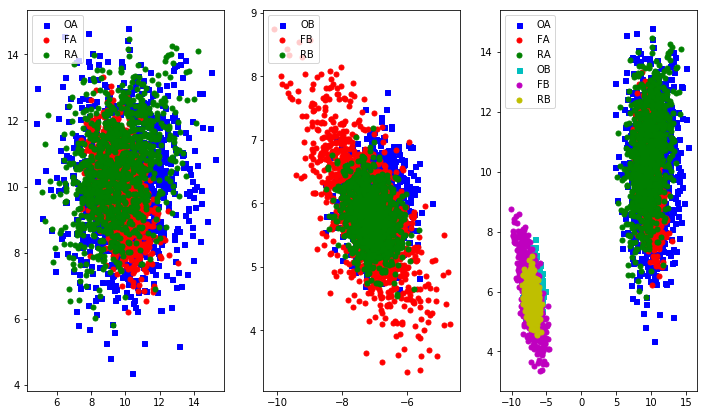

[Epoch 450/1000] [Batch 248/250] [D loss: 0.700020, acc:  18%] 
  [Translation AB Dist: 0.390673 BA Dist: 3.891558 Min AB Dist: 0.227434 Max AB: 0.522765 Min BA: 2.715805Max BA: 6.376253] 
 [G loss: 14.305616, adv: 0.685791, recon: 0.135095, id: 24.744112] time: 0:06:05.096792 
[Fake A Mean: (9, 9) Fake A Var: 0 A Mean: (9, 10) A Var: 2 ]
[Fake B Mean: (-7, 9) Fake B Var: 0 B Mean: (-6, 6) B Var: 0 ]


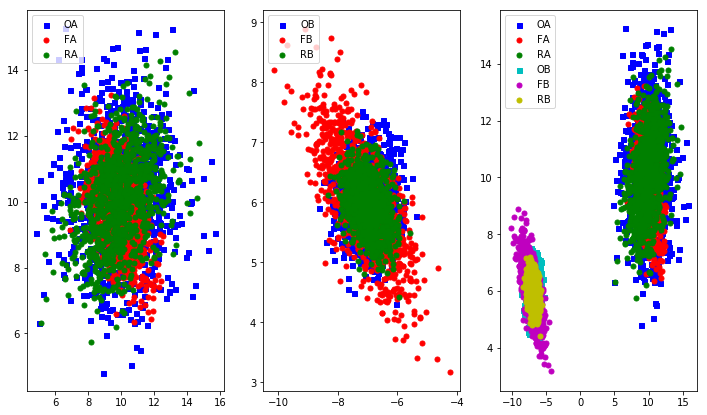

[Epoch 500/1000] [Batch 248/250] [D loss: 0.699941, acc:  18%] 
  [Translation AB Dist: 0.384008 BA Dist: 3.891929 Min AB Dist: 0.219249 Max AB: 0.515426 Min BA: 2.716566Max BA: 6.375435] 
 [G loss: 14.310779, adv: 0.686149, recon: 0.134156, id: 24.735821] time: 0:06:45.328762 
[Fake A Mean: (9, 9) Fake A Var: 0 A Mean: (10, 9) A Var: 2 ]
[Fake B Mean: (-7, 9) Fake B Var: 0 B Mean: (-6, 6) B Var: 0 ]


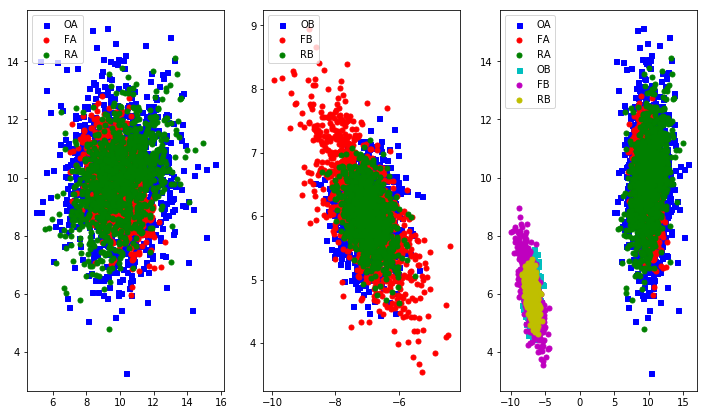

[Epoch 550/1000] [Batch 248/250] [D loss: 0.700071, acc:  18%] 
  [Translation AB Dist: 0.383685 BA Dist: 3.893476 Min AB Dist: 0.228373 Max AB: 0.510549 Min BA: 2.725909Max BA: 6.376912] 
 [G loss: 14.311874, adv: 0.685919, recon: 0.137525, id: 24.668541] time: 0:07:25.851787 
[Fake A Mean: (9, 9) Fake A Var: 0 A Mean: (9, 10) A Var: 3 ]
[Fake B Mean: (-7, 9) Fake B Var: 0 B Mean: (-7, 5) B Var: 0 ]


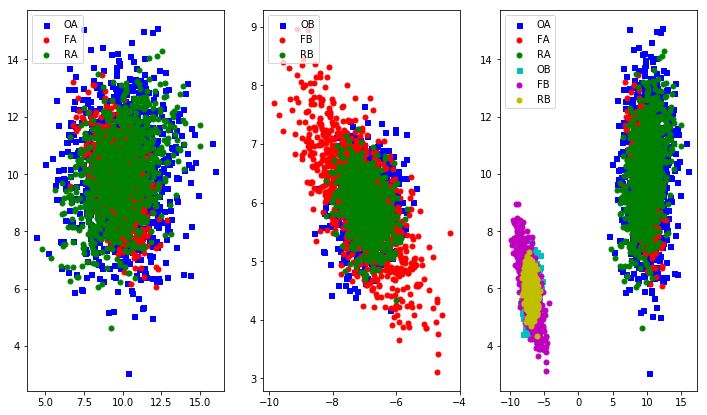

[Epoch 600/1000] [Batch 248/250] [D loss: 0.700445, acc:  18%] 
  [Translation AB Dist: 0.361153 BA Dist: 3.897824 Min AB Dist: 0.260242 Max AB: 0.447779 Min BA: 2.722855Max BA: 6.377939] 
 [G loss: 14.431334, adv: 0.685036, recon: 0.206418, id: 24.610968] time: 0:08:05.632840 
[Fake A Mean: (9, 9) Fake A Var: 0 A Mean: (9, 9) A Var: 2 ]
[Fake B Mean: (-7, 9) Fake B Var: 0 B Mean: (-7, 5) B Var: 0 ]


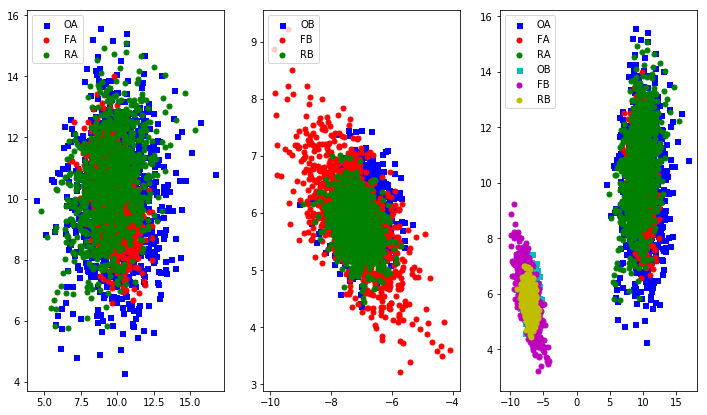

[Epoch 650/1000] [Batch 248/250] [D loss: 0.700216, acc:  18%] 
  [Translation AB Dist: 0.362025 BA Dist: 3.911039 Min AB Dist: 0.257325 Max AB: 0.460573 Min BA: 2.724651Max BA: 6.401077] 
 [G loss: 14.308565, adv: 0.685206, recon: 0.143749, id: 24.510061] time: 0:08:45.896622 
[Fake A Mean: (9, 9) Fake A Var: 0 A Mean: (9, 10) A Var: 2 ]
[Fake B Mean: (-7, 9) Fake B Var: 0 B Mean: (-6, 5) B Var: 0 ]


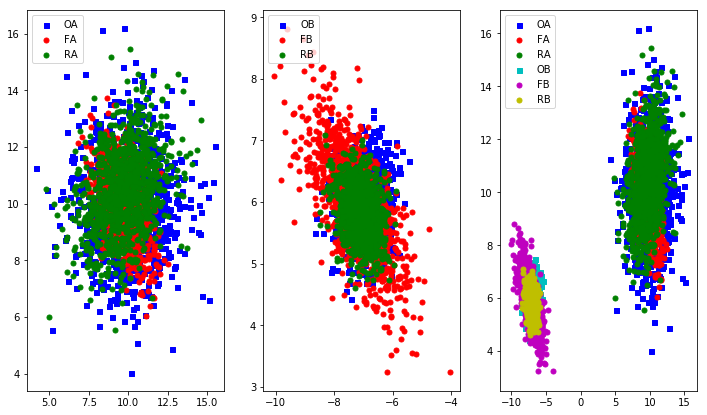

[Epoch 700/1000] [Batch 248/250] [D loss: 0.700210, acc:  18%] 
  [Translation AB Dist: 0.357802 BA Dist: 3.918688 Min AB Dist: 0.269392 Max AB: 0.445874 Min BA: 2.749693Max BA: 6.404372] 
 [G loss: 14.341080, adv: 0.685348, recon: 0.159015, id: 24.409279] time: 0:09:25.968477 
[Fake A Mean: (9, 9) Fake A Var: 0 A Mean: (10, 10) A Var: 3 ]
[Fake B Mean: (-7, 9) Fake B Var: 0 B Mean: (-7, 5) B Var: 0 ]


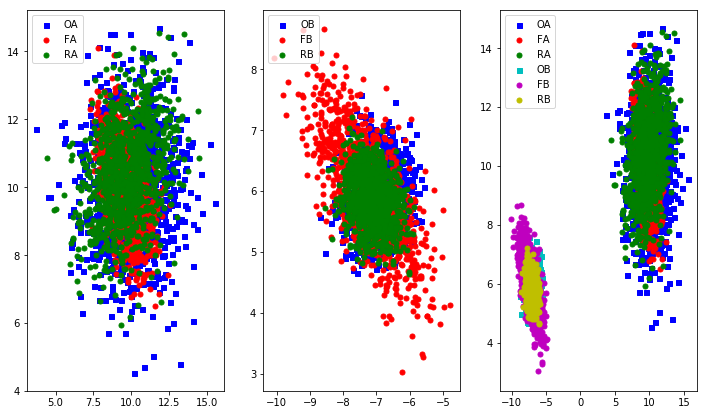

[Epoch 750/1000] [Batch 248/250] [D loss: 0.699981, acc:  18%] 
  [Translation AB Dist: 0.373400 BA Dist: 3.940036 Min AB Dist: 0.226739 Max AB: 0.486686 Min BA: 2.747688Max BA: 6.458855] 
 [G loss: 14.303267, adv: 0.685727, recon: 0.136625, id: 24.285967] time: 0:10:05.774876 
[Fake A Mean: (9, 9) Fake A Var: 0 A Mean: (9, 9) A Var: 3 ]
[Fake B Mean: (-7, 9) Fake B Var: 0 B Mean: (-6, 5) B Var: 0 ]


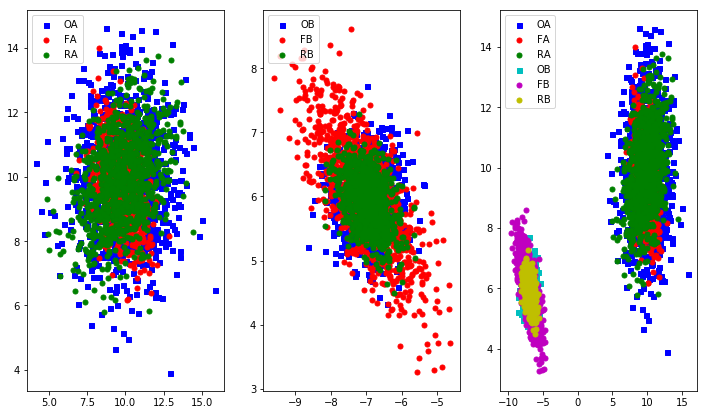

[Epoch 800/1000] [Batch 248/250] [D loss: 0.699812, acc:  18%] 
  [Translation AB Dist: 0.418825 BA Dist: 3.973798 Min AB Dist: 0.285639 Max AB: 0.546040 Min BA: 2.809951Max BA: 6.485687] 
 [G loss: 14.629339, adv: 0.685718, recon: 0.300183, id: 24.154362] time: 0:10:46.349590 
[Fake A Mean: (9, 9) Fake A Var: 0 A Mean: (10, 10) A Var: 2 ]
[Fake B Mean: (-7, 9) Fake B Var: 0 B Mean: (-7, 5) B Var: 0 ]


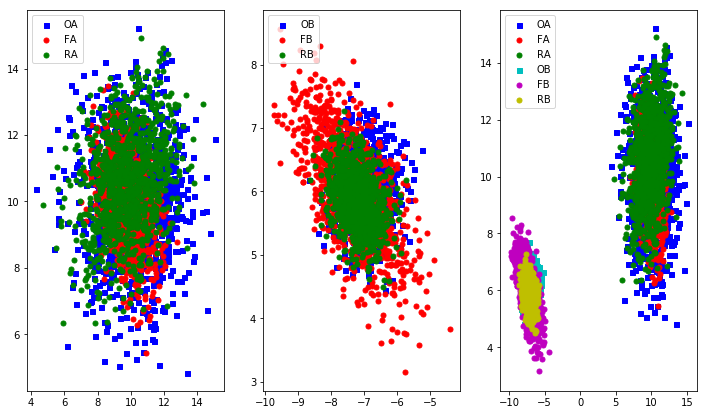

[Epoch 850/1000] [Batch 248/250] [D loss: 0.700066, acc:  18%] 
  [Translation AB Dist: 0.346649 BA Dist: 3.961619 Min AB Dist: 0.235886 Max AB: 0.453323 Min BA: 2.767518Max BA: 6.496021] 
 [G loss: 14.417760, adv: 0.685035, recon: 0.201739, id: 24.021236] time: 0:11:25.803135 
[Fake A Mean: (9, 9) Fake A Var: 0 A Mean: (10, 9) A Var: 3 ]
[Fake B Mean: (-7, 9) Fake B Var: 0 B Mean: (-7, 6) B Var: 0 ]


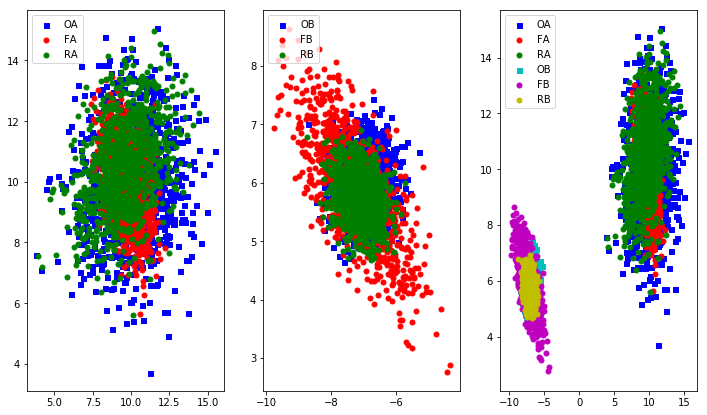

[Epoch 900/1000] [Batch 248/250] [D loss: 0.699871, acc:  18%] 
  [Translation AB Dist: 0.360506 BA Dist: 3.986452 Min AB Dist: 0.256122 Max AB: 0.463436 Min BA: 2.791060Max BA: 6.522156] 
 [G loss: 14.280149, adv: 0.685222, recon: 0.131211, id: 23.970362] time: 0:12:05.689319 
[Fake A Mean: (9, 9) Fake A Var: 0 A Mean: (9, 10) A Var: 2 ]
[Fake B Mean: (-7, 9) Fake B Var: 0 B Mean: (-6, 6) B Var: 0 ]


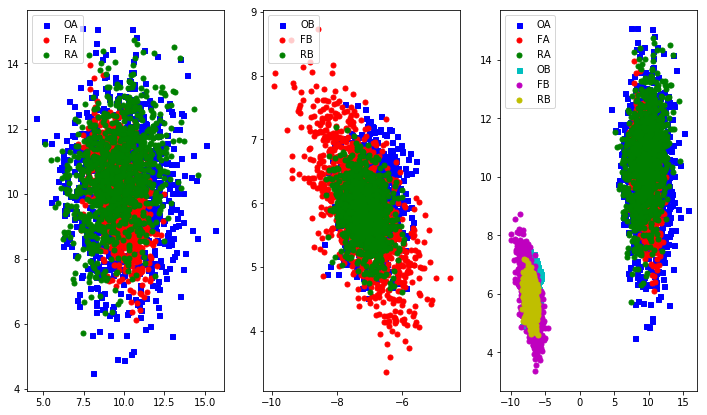

[Epoch 950/1000] [Batch 248/250] [D loss: 0.699530, acc:  18%] 
  [Translation AB Dist: 0.386875 BA Dist: 4.003473 Min AB Dist: 0.232128 Max AB: 0.493053 Min BA: 2.800102Max BA: 6.563898] 
 [G loss: 14.286272, adv: 0.685686, recon: 0.130501, id: 23.803469] time: 0:12:45.850627 
[Fake A Mean: (9, 9) Fake A Var: 0 A Mean: (9, 10) A Var: 3 ]
[Fake B Mean: (-7, 9) Fake B Var: 0 B Mean: (-6, 5) B Var: 0 ]


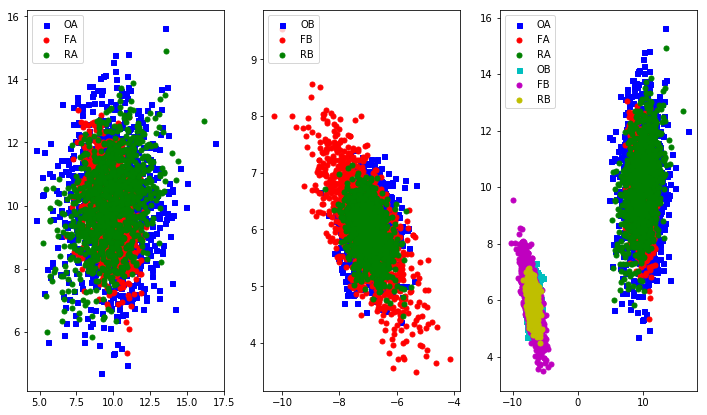

In [85]:
gan_10x_discloss=CycleGAN(data_A, data_B, disclossconst=10)
gan_10x_discloss.train(epochs=1000, batch_size=4, sample_interval=50)